In [2]:
import numpy as np
import cvxpy as cp

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

import pickle

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
from models.LISTA import LISTA_Net, LISTA
from models.L20_ISTA import L2O_ISTA
from models.TiLISTA import TiLISTA
from models.ALISTA import ALISTA

from utils.ISTA_FISTA import *
from utils.train import train, layerwise_train, layerwise_train_DC
from utils.synthetic_data import SyntheticSignals

In [4]:
torch.cuda.is_available()

True

In [119]:
class LDC_ISTA(nn.Module):
    def __init__(self, A, mode, lambd=0.1, p =0.012, p_max = 0.12, T = 5):
        super().__init__()
    
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        assert mode in ['EXP', 'PNEG', 'SCAD']

        self.mode = mode
        self.linear_shared = False
        self.A = A.to(self.device)  # Move A to the correct device
        self.A.requires_grad = False

        self.T = T

        self.L = torch.max(torch.real(torch.linalg.eigvals(A.t() @ A))).to(self.device)

        # Initialization of the learnable parameters
        self.lambd = nn.ParameterList([
            nn.Parameter(torch.tensor(1).reshape(1, 1).to(self.device) * lambd / self.L, requires_grad=True)
            for _ in range(self.T + 1)
        ])

        self.theta = nn.ParameterList([
            nn.Parameter(torch.tensor(1.0).reshape(1, 1).to(self.device), requires_grad=True)
            for _ in range(self.T + 1)
            ])
        
        # Linear layers
        self.Ws_1 = nn.ModuleList()
        self.Ws_2 = nn.ModuleList()
        
        for _ in range(self.T + 1):
            W1 = nn.Linear(A.shape[1], A.shape[0], bias=False).to(self.device)
            W2 = nn.Linear(A.shape[1], A.shape[1], bias=False).to(self.device)

            W1.weight.data = torch.clone(self.A.T).to(self.device) / self.L
            W2.weight.data = torch.eye(A.shape[1]).to(self.device) - torch.clone(A.t() @ A).to(self.device)/self.L
            self.Ws_1.append(W1)
            self.Ws_2.append(W2)


        # Support selection mechanism parameters
        self.p = p
        self.p_max = p_max

        # Losses when doing inference (placeholder for NMSE accumulation)
        self.losses = torch.zeros(self.T, device=self.device)
        self.est_powers = torch.zeros(self.T, device=self.device)

        # Mode setting for the layer
        if mode == 'EXP':
            self.ddx = self.ddxEXP
            self.eta = self.etaEXP

        if mode == 'PNEG':
            self.P = nn.ParameterList([
            nn.Parameter(torch.tensor(1.0).reshape(1, 1).to(self.device) * (-1), requires_grad=True)
            for _ in range(self.T + 1)
            ])            

            self.ddx = self.ddxNEG
            self.eta = self.etaNEG

        if mode == 'SCAD':
            self.a = nn.ParameterList([
            nn.Parameter(torch.tensor(1.0).reshape(1, 1).to(self.device), requires_grad=True)
            for _ in range(self.T + 1)
            ])        
            
            self.ddx = self.ddxSCAD
            self.eta = self.etaSCAD

    #_________________________________________________________________
    #______________ METHODS FOR ENABLING DIFFERENT LAYERS_____________
    #_________________________________________________________________
    
    # Derivatives of the nonconvex components
    def ddxEXP(self, x, t):
        return torch.sign(x) * self.theta[t] * (1 - torch.exp(-self.theta[t] * torch.abs(x)))

    def ddxNEG(self, x, t):
        return - torch.sign(x) * self.P[t] * self.theta[t] * (1 - (1 + self.theta[t] * torch.abs(x)) ** (self.P[t] - 1))

    def ddxSCAD(self, x, t):
        abs_x = torch.abs(x)

        mask1 = (abs_x <= 1)
        mask2 = (1 / self.theta[t] < abs_x) & (abs_x <= self.a[t] / self.theta[t])
        mask3 = (abs_x > self.a[t] / self.theta[t])

        # Compute the value for each condition
        val1 = torch.zeros_like(x)
        val2 = torch.sign(x) * (2 * self.theta[t] * (self.theta[t] * abs_x - 1)) / (self.a[t] ** 2 - 1)
        val3 = torch.sign(x) * (2 * self.theta[t] / (self.a[t] + 1))

        # Apply the masks to compute the final result
        result = torch.where(mask1, val1, torch.where(mask2, val2, val3))

        return result

    # Parametrization for the surrogates
    def etaEXP(self, t):
        return self.theta[t]

    def etaNEG(self, t):
        return -self.P[t] * self.theta[t]

    def etaSCAD(self, t):
        return 2 * self.theta[t] / (self.a[t] + 1)
    
    #___________________________________________________________________
    #___________________________________________________________________
        
    def _shrink(self, x, beta, t):
        # Get the absolute values of the elements in x
        abs_x = torch.abs(x)
        
        # Sort the elements of x by magnitude along the last dimension (num_features)
        sorted_abs_x, _ = torch.sort(abs_x, dim=-1, descending=True)

        # Determine the threshold index corresponding to the top p% elements in each sample
        p = torch.min(torch.tensor([self.p * t, self.p_max], device=self.device))
        threshold_idx = int(p * x.shape[-1])
        
        # Get the magnitude threshold for the top p% of elements (per batch)
        if threshold_idx > 0:
            threshold_value = sorted_abs_x[:, threshold_idx - 1:threshold_idx]  # Shape: (batch_size, 1)
        else:
            threshold_value = torch.zeros(x.shape[0], 1, device=x.device)  # Shape: (batch_size, 1)

        # Create a mask to exclude the top p% of elements from shrinkage
        mask = abs_x >= threshold_value
        
        # Apply soft thresholding only to elements outside the top p%
        x_shrink = beta * F.softshrink(x / beta, lambd=1)
        
        # Return the original values for the top p% and the shrinked values for others
        return torch.where(mask, x, x_shrink)

    
    def forward(self, y, its=None, S=None):     
        # Move inputs to the correct device
        if its is None:
            its = self.T

        y = y.to(self.device)
        if S is not None:
            S = S.to(self.device)

        # Initial sparse estimate using the first layer
        x = torch.zeros((y.shape[0], self.A.shape[1])).to(self.device)
        x = self._shrink(self.Ws_1[0](y) + self.lambd[0] * self.ddx(x, 0), self.eta(0) * self.lambd[0], 1)
        
        # Loop over layers to refine the estimate
        for t in range(1, its + 1):
            x = self._shrink(self.Ws_2[t](x) + self.Ws_1[t](y) + self.lambd[t] * self.ddx(x, t), 
                             self.eta(t) * self.lambd[t],
                             t)
            
            if S is not None:  # During inference, compute the NMSE at each layer
                with torch.no_grad():
                    mse_loss = F.mse_loss(x.detach(), S.detach(), reduction="sum")
                    signal_power = torch.sum(S.detach() ** 2)

                    self.losses[t - 1] += mse_loss.item()
                    self.est_powers[t - 1] += signal_power.item() + 1e-6

        return x

    # Method to compute NMSE during inference mode
    def compute_nmse_inference(self, test_loader):
        # Reset the losses accumulator
        self.losses = torch.zeros(self.T, device=self.device)
        
        # Iterate over test_loader
        for _, (Y, S) in enumerate(test_loader):
            Y, S = Y.to(self.device), S.to(self.device)
            _ = self.forward(Y, its = None, S = S)  # This will accumulate NMSE values
        
        # Convert accumulated NMSE to dB
        nmse_db = 10 * torch.log10(self.losses / self.est_powers)
        
        # Reset the losses after inference
        self.losses = torch.zeros(self.T, device=self.device)
        self.est_powers = torch.zeros(self.T, device=self.device)

        # Return NMSE in dB for each layer
        return nmse_db

In [124]:
import torch.optim as optim

def layerwise_train_DC(
        model, 
        train_loader, 
        valid_loader, 
        model_class,
        DCSIP,
        lr=5e-4, 
        ft_lr=3e-5,
        num_epochs=100, 
        verbose=True, 
        clip_value=10.0, 
        eps=1e-6, 
        fine_tune_epochs=100, 
        patience=10):

    assert model_class in [
        'L-DC-ISTA',
        'LISTA-DC-CPSS',
        'TIL-DC-ISTA',
        'AL-DC-ISTA'
    ]

    assert DCSIP in [
        'EXP',
        'PNEG',
        'SCAD'
    ]

    device = model.device
    model = model.to(device)

    linear_shared = model.linear_shared

    loss_train_all = {}
    loss_test_all = {}

    T = model.T  # Number of layers/iterations

    for t in range(T):

        if verbose:
            print(f"===== Training Layer {t+1}/{T} =====")

        # Freeze parameters beyond current layer t
        for layer_idx in range(t):
            
            if DCSIP == 'SCAD':
                model.a[layer_idx].requires_grad = False
            if DCSIP == 'PNEG':
                model.P[layer_idx].requires_grad = False
                
            model.lambd[layer_idx].requires_grad = False
            model.theta[layer_idx].requires_grad = False

            if model_class != 'L-DC-ISTA' and linear_shared == True:
                model.mu[layer_idx].requires_grad = False

            if not linear_shared:
                if model_class == 'L-DC-ISTA':
                    model.Ws_1[layer_idx].weight.requires_grad = False
                    model.Ws_2[layer_idx].weight.requires_grad = False
                if model_class == 'L-DC-ISTA-CPSS':
                    model.Ws[layer_idx].weight.requires_grad = False            


        # Define optimizer to include W1, W2, and parameters up to layer t
        if model_class == 'L-DC-ISTA':
            params = list(model.lambd)[:t+1] + list(model.theta)[:t+1] 
            if DCSIP == 'PNEG':
                params += list(model.P)[:t+1]
            if DCSIP == 'SCAD':
                params += list(model.a)[:t+1]
            if not linear_shared:
                optimizer = optim.Adam(
                    list(model.Ws_1.parameters())[:t+1] + 
                    list(model.Ws_2.parameters())[:t+1] + 
                    params,
                    lr=lr,
                    eps=eps
                )

        if model_class == 'LISTA-CPSS':
            optimizer = optim.Adam(
                list(model.Ws.parameters())[:t+1] +
                list(model.beta)[:t+1],
                lr=lr,
                eps=eps
            )

        if model_class == 'TILISTA':
            optimizer = optim.Adam(
                list(model.W.parameters()) +
                list(model.beta)[:t+1] + 
                list(model.mu)[:t+1],
                lr=lr,
                eps=eps
            )

        if model_class == 'AL-DC-ISTA':
            params = list(model.lambd)[:t+1] + list(model.theta)[:t+1] + list(model.mu)[:t+1]
            if DCSIP == 'PNEG':
                params += list(model.P)[:t+1]
            if DCSIP == 'SCAD':
                params += list(model.a)[:t+1]
            optimizer = optim.Adam(
                params,
                lr=lr,
                eps=eps
            )

        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

        # Initialize loss tracking for current layer
        loss_train = np.zeros((num_epochs,))
        loss_test = np.zeros((num_epochs,))

        # Early stopping variables
        best_val_loss = float('inf')
        epochs_since_improvement = 0
        best_model_state = None

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            signal_power_train = 0.0

            for Y, S in train_loader:
                Y = Y.to(device)
                S = S.to(device)

                optimizer.zero_grad()
                S_hat = model(y=Y, its=t, S = None)

                mse_loss = F.mse_loss(S_hat, S, reduction="sum")
                signal_power = torch.sum(S ** 2)

                loss = mse_loss
                loss.backward()

                # Apply gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

                optimizer.step()

                train_loss += mse_loss.item()
                signal_power_train += signal_power.item()

            # Compute NMSE in dB for training set
            nmse_train = train_loss / (signal_power_train + eps)
            loss_train[epoch] = 10 * np.log10(nmse_train + eps)
            scheduler.step()

            # Validation
            model.eval()
            test_loss_epoch = 0.0
            signal_power_test = 0.0

            with torch.no_grad():
                for Y, S in valid_loader:
                    Y = Y.to(device)
                    S = S.to(device)

                    S_hat = model(Y, its=t)

                    mse_loss = F.mse_loss(S_hat, S, reduction="sum")
                    signal_power = torch.sum(S ** 2)

                    test_loss_epoch += mse_loss.item()
                    signal_power_test += signal_power.item()

            nmse_test = test_loss_epoch / (signal_power_test + eps)
            loss_test[epoch] = 10 * np.log10(nmse_test + eps)

            if verbose and (epoch % 10 == 0 or epoch == num_epochs - 1):
                print(
                    f"Layer {t+1}, Epoch {epoch+1}/{num_epochs}, "
                    f"Train NMSE (dB): {loss_train[epoch]:.6f}, "
                    f"Validation NMSE (dB): {loss_test[epoch]:.6f}"
                )

            # Early stopping check
            if loss_test[epoch] < best_val_loss:
                best_val_loss = loss_test[epoch]
                epochs_since_improvement = 0
                best_model_state = model.state_dict()  # Save the best model state
            else:
                epochs_since_improvement += 1

            if epochs_since_improvement >= patience:
                if verbose:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                model.load_state_dict(best_model_state)  # Restore best model state
                break

        # Store losses for current layer
        loss_train_all[f"Layer_{t+1}"] = loss_train[:epoch+1]
        loss_test_all[f"Layer_{t+1}"] = loss_test[:epoch+1]

        if verbose:
            print(f"===== Finished Training Layer {t+1}/{T} =====\n")

        # Optionally, fine-tune the entire network
        if fine_tune_epochs > 0:
            if verbose:
                print("===== Fine-Tuning the Entire Network =====")

            # Unfreeze all parameters
            for layer_idx in range(t + 1):                
                if DCSIP == 'SCAD':
                    model.a[layer_idx].requires_grad = True
                if DCSIP == 'PNEG':
                    model.P[layer_idx].requires_grad = True
                    
                model.lambd[layer_idx].requires_grad = True
                model.theta[layer_idx].requires_grad = True

                if model_class != 'L-DC-ISTA' and linear_shared == True:
                    model.mu[layer_idx].requires_grad = True

                if not linear_shared:
                    if model_class == 'L-DC-ISTA':
                        model.Ws_1[layer_idx].weight.requires_grad = True
                        model.Ws_2[layer_idx].weight.requires_grad = True
                    if model_class == 'L-DC-ISTA-CPSS':
                        model.Ws[layer_idx].weight.requires_grad = True       

            if model_class == 'L-DC-ISTA':
                params = list(model.lambd)[:t+1] + list(model.theta)[:t+1] 
                if DCSIP == 'PNEG':
                    params += list(model.P)[:t+1]
                if DCSIP == 'SCAD':
                    params += list(model.a)[:t+1]
                if not linear_shared:
                    optimizer = optim.Adam(
                        list(model.Ws_1.parameters())[:t+1] + 
                        list(model.Ws_2.parameters())[:t+1] + 
                        params,
                        lr=lr,
                        eps=eps
                    )

            if model_class == 'LISTA-CPSS':
                optimizer = optim.Adam(
                    list(model.Ws.parameters())[:t+1] +
                    list(model.beta)[:t+1],
                    lr=ft_lr,
                    eps=eps
                )

            if model_class == 'TILISTA':
                optimizer = optim.Adam(
                    list(model.W.parameters()) +
                    list(model.beta)[:t+1] + 
                    list(model.mu)[:t+1],
                    lr=ft_lr,
                    eps=eps
                )

            if model_class == 'AL-DC-ISTA':
                params = list(model.lambd)[:t+1] + list(model.theta)[:t+1] + list(model.mu)[:t+1]
                if DCSIP == 'PNEG':
                    params += list(model.P)[:t+1]
                if DCSIP == 'SCAD':
                    params += list(model.a)[:t+1]
                optimizer = optim.Adam(
                    params,
                    lr=lr,
                    eps=eps
                )

            scheduler_ft = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

            # Initialize loss tracking for fine-tuning
            loss_train_ft = np.zeros((fine_tune_epochs,))
            loss_test_ft = np.zeros((fine_tune_epochs,))

            best_val_loss_ft = float('inf')
            epochs_since_improvement_ft = 0
            best_model_state_ft = None

            for epoch in range(fine_tune_epochs):
                model.train()
                train_loss = 0.0
                signal_power_train = 0.0

                for Y, S in train_loader:
                    Y = Y.to(device)
                    S = S.to(device)

                    optimizer.zero_grad()
                    S_hat = model(Y, its=t)

                    mse_loss = F.mse_loss(S_hat, S, reduction="sum")
                    signal_power = torch.sum(S ** 2)

                    loss = mse_loss
                    loss.backward()

                    # Apply gradient clipping
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

                    optimizer.step()

                    train_loss += mse_loss.item()
                    signal_power_train += signal_power.item()

                # Compute NMSE in dB for training set
                nmse_train = train_loss / (signal_power_train + eps)
                loss_train_ft[epoch] = 10 * np.log10(nmse_train + eps)
                scheduler_ft.step()

                # Validation
                model.eval()
                test_loss_epoch = 0.0
                signal_power_test = 0.0

                with torch.no_grad():
                    for Y, S in valid_loader:
                        Y = Y.to(device)
                        S = S.to(device)

                        S_hat = model(Y, its=t)

                        mse_loss = F.mse_loss(S_hat, S, reduction="sum")
                        signal_power = torch.sum(S ** 2)

                        test_loss_epoch += mse_loss.item()
                        signal_power_test += signal_power.item()

                nmse_test = test_loss_epoch / (signal_power_test + eps)
                loss_test_ft[epoch] = 10 * np.log10(nmse_test + eps)

                if verbose and (epoch % 10 == 0 or epoch == fine_tune_epochs - 1):
                    print(
                        f"Fine-Tune Epoch {epoch+1}/{fine_tune_epochs}, "
                        f"Train NMSE (dB): {loss_train_ft[epoch]:.6f}, "
                        f"Validation NMSE (dB): {loss_test_ft[epoch]:.6f}"
                    )

                # Early stopping for fine-tuning
                if loss_test_ft[epoch] < best_val_loss_ft:
                    best_val_loss_ft = loss_test_ft[epoch]
                    epochs_since_improvement_ft = 0
                    best_model_state_ft = model.state_dict()  # Save the best model state
                else:
                    epochs_since_improvement_ft += 1

                if epochs_since_improvement_ft >= patience:
                    if verbose:
                        print(f"Early stopping for fine-tuning triggered after {epoch+1} epochs")
                    model.load_state_dict(best_model_state_ft)  # Restore best model state
                    break

            # Store fine-tuning losses
            loss_train_all["Fine_Tune"] = loss_train_ft[:epoch+1]
            loss_test_all["Fine_Tune"] = loss_test_ft[:epoch+1]

            if verbose:
                print("===== Finished Fine-Tuning =====\n")

    return loss_train_all, loss_test_all

In [50]:
n_ = 500
m_ = 250
p_ = 0.1

# Sensing matrix

A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
A_ /= torch.linalg.norm(A_, dim = 0)

# Building a training set and a test set 
train_set = SyntheticSignals(
    A = A_,
    n = n_,        
    m = m_,
    p = p_,
    SNR = None,
    size = 10000,
    batch_size = 1000
    ).set_loader()

test_set = SyntheticSignals(
    A = A_,
    n = n_,        
    m = m_,
    p = p_,
    SNR = None,
    size = 1000
    ).set_loader()

In [75]:
model2 = LISTA(torch.clone(A_), 0.4, T = 16)

In [77]:
layerwise_train(model2, train_set, test_set, model_class='LISTA',lr = 3e-3, verbose = True)

===== Training Layer 1/16 =====
Layer 1, Epoch 1/100, Train NMSE (dB): -1.920432, Validation NMSE (dB): -2.480774
Layer 1, Epoch 11/100, Train NMSE (dB): -6.050169, Validation NMSE (dB): -5.594059
Layer 1, Epoch 21/100, Train NMSE (dB): -6.549745, Validation NMSE (dB): -5.699549
Early stopping triggered after 24 epochs
===== Finished Training Layer 1/16 =====

===== Fine-Tuning the Entire Network =====
Fine-Tune Epoch 1/100, Train NMSE (dB): -6.693543, Validation NMSE (dB): -5.696904
Fine-Tune Epoch 11/100, Train NMSE (dB): -6.704248, Validation NMSE (dB): -5.700602
Fine-Tune Epoch 21/100, Train NMSE (dB): -6.710351, Validation NMSE (dB): -5.704369
Fine-Tune Epoch 31/100, Train NMSE (dB): -6.713469, Validation NMSE (dB): -5.706460
Fine-Tune Epoch 41/100, Train NMSE (dB): -6.715829, Validation NMSE (dB): -5.708848
Fine-Tune Epoch 51/100, Train NMSE (dB): -6.719496, Validation NMSE (dB): -5.709773
Fine-Tune Epoch 61/100, Train NMSE (dB): -6.719139, Validation NMSE (dB): -5.709997
Fine-Tu

({'Layer_1': array([-1.92043246, -2.88571094, -3.41079415, -3.84789003, -4.25441862,
         -4.67439425, -5.04999283, -5.3672955 , -5.63783954, -5.86551052,
         -6.05016868, -6.19011014, -6.28384644, -6.33746024, -6.36641272,
         -6.40006521, -6.44975011, -6.48637434, -6.51942524, -6.53811173,
         -6.54974506, -6.56048106, -6.57055089, -6.57595189]),
  'Fine_Tune': array([-38.41667969, -38.86698807, -39.34468677, -39.58462131,
         -39.70669701, -39.76910051, -39.80545531, -39.81738014,
         -39.84876352, -39.86376178, -39.87505626, -39.89970872]),
  'Layer_2': array([ -7.23274444,  -7.95729796,  -8.38306554,  -8.66589004,
          -8.88441369,  -9.06395879,  -9.21033797,  -9.35133675,
          -9.51129363,  -9.63138714,  -9.78950612,  -9.87992582,
         -10.03598787, -10.11136041, -10.26448484, -10.31318847,
         -10.46172288, -10.49620667, -10.61390129, -10.6806513 ,
         -10.7635909 , -10.86470973, -10.91777053, -11.00848201,
         -11.064042

In [136]:
model = LDC_ISTA(torch.clone(A_), 'EXP', 1, T = 16)

In [138]:
model.compute_nmse_inference(test_set)

tensor([ -5.3020,  -6.4132,  -9.1098, -10.8656, -11.8027, -12.3323, -12.7461,
        -13.0968, -13.4556, -13.9103, -14.3777, -14.8476, -15.2634, -15.5288,
        -15.6493, -15.1554], device='cuda:0')

In [137]:
layerwise_train_DC(model, train_set, test_set, model_class = 'L-DC-ISTA', DCSIP = 'EXP', lr = 5e-4, ft_lr=5e-7)

===== Training Layer 1/16 =====
Layer 1, Epoch 1/100, Train NMSE (dB): -1.056808, Validation NMSE (dB): -1.273786
Layer 1, Epoch 11/100, Train NMSE (dB): -3.776902, Validation NMSE (dB): -3.576556
Layer 1, Epoch 21/100, Train NMSE (dB): -4.799551, Validation NMSE (dB): -4.460341
Layer 1, Epoch 31/100, Train NMSE (dB): -5.555997, Validation NMSE (dB): -5.084311
Layer 1, Epoch 41/100, Train NMSE (dB): -6.111807, Validation NMSE (dB): -5.496707
Layer 1, Epoch 51/100, Train NMSE (dB): -6.462211, Validation NMSE (dB): -5.670495
Layer 1, Epoch 61/100, Train NMSE (dB): -6.483032, Validation NMSE (dB): -5.677855
Layer 1, Epoch 71/100, Train NMSE (dB): -6.496519, Validation NMSE (dB): -5.683121
Layer 1, Epoch 81/100, Train NMSE (dB): -6.508459, Validation NMSE (dB): -5.687691
Layer 1, Epoch 91/100, Train NMSE (dB): -6.518264, Validation NMSE (dB): -5.690950
Layer 1, Epoch 100/100, Train NMSE (dB): -6.526422, Validation NMSE (dB): -5.694036
===== Finished Training Layer 1/16 =====

===== Fine-Tu

({'Layer_1': array([-1.0568081 , -1.49993005, -1.92631356, -2.32700979, -2.71366978,
         -3.05831677, -3.27844287, -3.42880683, -3.55132766, -3.66456189,
         -3.77690188, -3.89071885, -4.00495682, -4.11750282, -4.22643453,
         -4.33093814, -4.43128157, -4.52795274, -4.62123057, -4.71155905,
         -4.79955143, -4.88466468, -4.96768576, -5.04851529, -5.12735866,
         -5.20386161, -5.27812717, -5.35057902, -5.42098188, -5.48973943,
         -5.55599665, -5.62061481, -5.68290445, -5.74399991, -5.80262628,
         -5.8595196 , -5.91320491, -5.96580425, -6.01712023, -6.0655624 ,
         -6.1118067 , -6.15520595, -6.19707071, -6.23623725, -6.27248337,
         -6.30678722, -6.34029221, -6.36831278, -6.396432  , -6.42030436,
         -6.46221138, -6.46505006, -6.46791676, -6.47019799, -6.47230857,
         -6.47425867, -6.47633041, -6.47784695, -6.48022319, -6.481507  ,
         -6.4830318 , -6.48448281, -6.4855078 , -6.48739017, -6.48901451,
         -6.49020103, -6.49

In [139]:
[model.theta[t].detach() for t in range(model.T)]

[tensor([[1.2038]], device='cuda:0'),
 tensor([[2.5330]], device='cuda:0'),
 tensor([[2.5881]], device='cuda:0'),
 tensor([[1.8447]], device='cuda:0'),
 tensor([[1.5729]], device='cuda:0'),
 tensor([[1.3329]], device='cuda:0'),
 tensor([[1.0823]], device='cuda:0'),
 tensor([[0.9396]], device='cuda:0'),
 tensor([[0.8828]], device='cuda:0'),
 tensor([[0.7103]], device='cuda:0'),
 tensor([[0.7029]], device='cuda:0'),
 tensor([[0.7248]], device='cuda:0'),
 tensor([[0.7633]], device='cuda:0'),
 tensor([[0.8059]], device='cuda:0'),
 tensor([[0.8557]], device='cuda:0'),
 tensor([[0.8928]], device='cuda:0')]

In [140]:
[model.lambd[t].detach() * model.eta(t) for t in range(model.T)]

[tensor([[0.4103]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.2961]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.1194]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.0560]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.0361]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.0293]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.0259]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.0430]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.0393]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.0280]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.0226]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.0249]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.0251]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.0250]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.0229]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.0581]], device='cuda:0', grad_fn=<MulBackward0>)]

In [90]:
[torch.linalg.norm(model.Ws_3[t].weight.data) for t in range(model.T)]

[tensor(1.5666, device='cuda:0'),
 tensor(35.8301, device='cuda:0'),
 tensor(22.9912, device='cuda:0'),
 tensor(18.1696, device='cuda:0'),
 tensor(23.3411, device='cuda:0'),
 tensor(29.3183, device='cuda:0'),
 tensor(39.5211, device='cuda:0'),
 tensor(46.7524, device='cuda:0'),
 tensor(50.5844, device='cuda:0'),
 tensor(47.6080, device='cuda:0'),
 tensor(48.6159, device='cuda:0'),
 tensor(42.8521, device='cuda:0'),
 tensor(25.0908, device='cuda:0'),
 tensor(24.9328, device='cuda:0'),
 tensor(22.8825, device='cuda:0'),
 tensor(20.8946, device='cuda:0')]

In [145]:
[torch.linalg.norm(torch.eye(500).to('cuda:0') - model.Ws_1[t].weight.data @ model.A - model.Ws_2[t].weight.data ) for t in range(model.T)]

[tensor(29.4942, device='cuda:0'),
 tensor(17.1490, device='cuda:0'),
 tensor(13.1171, device='cuda:0'),
 tensor(6.0148, device='cuda:0'),
 tensor(2.4450, device='cuda:0'),
 tensor(1.3491, device='cuda:0'),
 tensor(0.8874, device='cuda:0'),
 tensor(1.1671, device='cuda:0'),
 tensor(1.0340, device='cuda:0'),
 tensor(0.8641, device='cuda:0'),
 tensor(0.7280, device='cuda:0'),
 tensor(0.7470, device='cuda:0'),
 tensor(0.7696, device='cuda:0'),
 tensor(0.8227, device='cuda:0'),
 tensor(0.9746, device='cuda:0'),
 tensor(1.2145, device='cuda:0')]

In [5]:
M = 10
LAYERS = 5
BETA_INIT = 0.4
EPOCHS = 50
SNR = None

LISTA_LOSS = torch.zeros((M, LAYERS))
LDC_LISTA_EXP_LOSS = torch.zeros((M, LAYERS))
LDC_LISTA_PNEG_LOSS = torch.zeros((M, LAYERS))
LDC_LISTA_SCAD_LOSS = torch.zeros((M, LAYERS))

ISTA_LOSS = torch.zeros((M, LAYERS))
FISTA_LOSS = torch.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 200
    m_ = 150
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = LISTA_Net(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = LDC_ISTA(torch.clone(A_), 'EXP', BETA_INIT, T = LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = LDC_ISTA(torch.clone(A_), 'PNEG', BETA_INIT, T = LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = LDC_ISTA(torch.clone(A_), 'SCAD', BETA_INIT, T = LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    LISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set)
    LDC_LISTA_EXP_LOSS[m,:] = model2.compute_nmse_inference(test_set)
    LDC_LISTA_PNEG_LOSS[m,:] = model3.compute_nmse_inference(test_set)
    LDC_LISTA_SCAD_LOSS[m,:] = model4.compute_nmse_inference(test_set)

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)

100%|██████████| 10/10 [08:32<00:00, 51.24s/it]


In [6]:
LISTA_LOSS = LISTA_LOSS.cpu().numpy()
LDC_LISTA_EXP_LOSS = LDC_LISTA_EXP_LOSS.cpu().numpy()
LDC_LISTA_PNEG_LOSS = LDC_LISTA_PNEG_LOSS.cpu().numpy()
LDC_LISTA_SCAD_LOSS = LDC_LISTA_SCAD_LOSS.cpu().numpy()

ISTA_LOSS = ISTA_LOSS.cpu().numpy()
FISTA_LOSS = FISTA_LOSS.cpu().numpy()

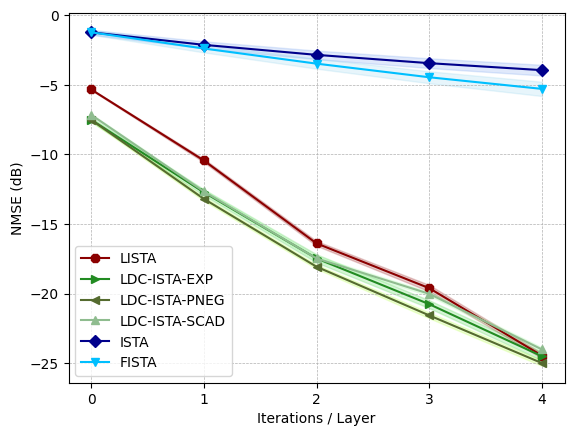

In [7]:
plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.2)

plt.plot(np.mean(LDC_LISTA_EXP_LOSS, axis = 0), label='LDC-ISTA-EXP', color='forestgreen', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(LDC_LISTA_EXP_LOSS, axis = 0) - (2/np.sqrt(LDC_LISTA_EXP_LOSS.shape[1])) * np.std(LDC_LISTA_EXP_LOSS, axis = 0), 
                    np.mean(LDC_LISTA_EXP_LOSS, axis = 0) + (2/np.sqrt(LDC_LISTA_EXP_LOSS.shape[1])) * np.std(LDC_LISTA_EXP_LOSS, axis = 0), 
                    color='limegreen', 
                    alpha=0.2)

plt.plot(np.mean(LDC_LISTA_PNEG_LOSS, axis = 0), label='LDC-ISTA-PNEG', color='darkolivegreen', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(LDC_LISTA_PNEG_LOSS, axis = 0) - (2/np.sqrt(LDC_LISTA_PNEG_LOSS.shape[1])) * np.std(LDC_LISTA_PNEG_LOSS, axis = 0), 
                    np.mean(LDC_LISTA_PNEG_LOSS, axis = 0) + (2/np.sqrt(LDC_LISTA_PNEG_LOSS.shape[1])) * np.std(LDC_LISTA_PNEG_LOSS, axis = 0), 
                    color='greenyellow', 
                    alpha=0.2)

plt.plot(np.mean(LDC_LISTA_SCAD_LOSS, axis = 0), label='LDC-ISTA-SCAD', color='darkseagreen', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(LDC_LISTA_SCAD_LOSS, axis = 0) - (2/np.sqrt(LDC_LISTA_SCAD_LOSS.shape[1])) * np.std(LDC_LISTA_SCAD_LOSS, axis = 0), 
                    np.mean(LDC_LISTA_SCAD_LOSS, axis = 0) + (2/np.sqrt(LDC_LISTA_SCAD_LOSS.shape[1])) * np.std(LDC_LISTA_SCAD_LOSS, axis = 0), 
                    color='palegreen', 
                    alpha=0.2)

plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.xticks(range(LAYERS))

plt.ylabel('NMSE (dB)')
plt.xlabel('Iterations / Layer')


plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

In [8]:
exp_1 = {
    'LISTA':LISTA_LOSS,
    'LDC-LISTA-EXP':LDC_LISTA_EXP_LOSS,
    'LDC-LISTA-PNEG':LDC_LISTA_PNEG_LOSS,
    'LDC-LISTA-SCAD':LDC_LISTA_SCAD_LOSS,
    'ISTA':ISTA_LOSS,
    'FISTA':FISTA_LOSS
}

with open('LDC-LISTA_1.pkl', 'wb') as handle:
    pickle.dump(exp_1, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
M = 10
LAYERS = 16
BETA_INIT = 0.4
EPOCHS = 50
SNR = 1000

LISTA_LOSS = torch.zeros((M, LAYERS))
LDC_LISTA_EXP_LOSS = torch.zeros((M, LAYERS))
LDC_LISTA_PNEG_LOSS = torch.zeros((M, LAYERS))
LDC_LISTA_SCAD_LOSS = torch.zeros((M, LAYERS))

ISTA_LOSS = torch.zeros((M, LAYERS))
FISTA_LOSS = torch.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 500
    m_ = 250
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = LISTA_Net(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = LDC_ISTA(torch.clone(A_), 'EXP', BETA_INIT, T = LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = LDC_ISTA(torch.clone(A_), 'PNEG', BETA_INIT, T = LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = LDC_ISTA(torch.clone(A_), 'SCAD', BETA_INIT, T = LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    LISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set)
    LDC_LISTA_EXP_LOSS[m,:] = model2.compute_nmse_inference(test_set)
    LDC_LISTA_PNEG_LOSS[m,:] = model3.compute_nmse_inference(test_set)
    LDC_LISTA_SCAD_LOSS[m,:] = model4.compute_nmse_inference(test_set)

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)

100%|██████████| 10/10 [21:32<00:00, 129.29s/it]


In [10]:
LISTA_LOSS = LISTA_LOSS.cpu().numpy()
LDC_LISTA_EXP_LOSS = LDC_LISTA_EXP_LOSS.cpu().numpy()
LDC_LISTA_PNEG_LOSS = LDC_LISTA_PNEG_LOSS.cpu().numpy()
LDC_LISTA_SCAD_LOSS = LDC_LISTA_SCAD_LOSS.cpu().numpy()

ISTA_LOSS = ISTA_LOSS.cpu().numpy()
FISTA_LOSS = FISTA_LOSS.cpu().numpy()

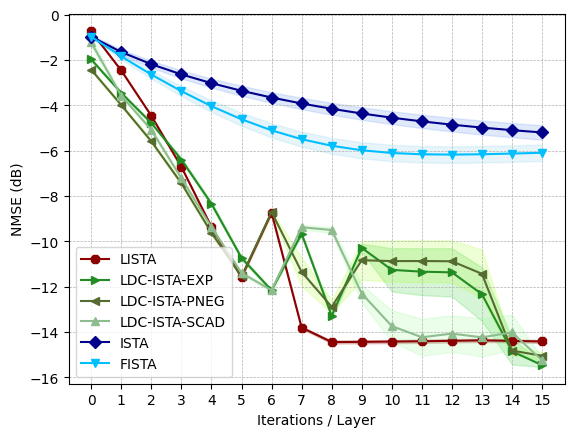

In [11]:
plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.2)

plt.plot(np.mean(LDC_LISTA_EXP_LOSS, axis = 0), label='LDC-ISTA-EXP', color='forestgreen', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(LDC_LISTA_EXP_LOSS, axis = 0) - (2/np.sqrt(LDC_LISTA_EXP_LOSS.shape[1])) * np.std(LDC_LISTA_EXP_LOSS, axis = 0), 
                    np.mean(LDC_LISTA_EXP_LOSS, axis = 0) + (2/np.sqrt(LDC_LISTA_EXP_LOSS.shape[1])) * np.std(LDC_LISTA_EXP_LOSS, axis = 0), 
                    color='limegreen', 
                    alpha=0.2)

plt.plot(np.mean(LDC_LISTA_PNEG_LOSS, axis = 0), label='LDC-ISTA-PNEG', color='darkolivegreen', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(LDC_LISTA_PNEG_LOSS, axis = 0) - (2/np.sqrt(LDC_LISTA_PNEG_LOSS.shape[1])) * np.std(LDC_LISTA_PNEG_LOSS, axis = 0), 
                    np.mean(LDC_LISTA_PNEG_LOSS, axis = 0) + (2/np.sqrt(LDC_LISTA_PNEG_LOSS.shape[1])) * np.std(LDC_LISTA_PNEG_LOSS, axis = 0), 
                    color='greenyellow', 
                    alpha=0.2)

plt.plot(np.mean(LDC_LISTA_SCAD_LOSS, axis = 0), label='LDC-ISTA-SCAD', color='darkseagreen', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(LDC_LISTA_SCAD_LOSS, axis = 0) - (2/np.sqrt(LDC_LISTA_SCAD_LOSS.shape[1])) * np.std(LDC_LISTA_SCAD_LOSS, axis = 0), 
                    np.mean(LDC_LISTA_SCAD_LOSS, axis = 0) + (2/np.sqrt(LDC_LISTA_SCAD_LOSS.shape[1])) * np.std(LDC_LISTA_SCAD_LOSS, axis = 0), 
                    color='palegreen', 
                    alpha=0.2)

plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.xticks(range(LAYERS))

plt.ylabel('NMSE (dB)')
plt.xlabel('Iterations / Layer')

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

In [12]:
exp_2 = {
    'LISTA':LISTA_LOSS,
    'LDC-ISTA-EXP':LDC_LISTA_EXP_LOSS,
    'LDC-ISTA-PNEG':LDC_LISTA_PNEG_LOSS,
    'LDC-ISTA-SCAD':LDC_LISTA_SCAD_LOSS,
    'ISTA':ISTA_LOSS,
    'FISTA':FISTA_LOSS
}

with open('LDC-LISTA_2.pkl', 'wb') as handle:
    pickle.dump(exp_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
M = 10
LAYERS = 20
BETA_INIT = 0.4
EPOCHS = 50
SNR = 1000

LISTA_LOSS = torch.zeros((M, LAYERS))
LDC_LISTA_EXP_LOSS = torch.zeros((M, LAYERS))
LDC_LISTA_PNEG_LOSS = torch.zeros((M, LAYERS))
LDC_LISTA_SCAD_LOSS = torch.zeros((M, LAYERS))

ISTA_LOSS = torch.zeros((M, LAYERS))
FISTA_LOSS = torch.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 500
    m_ = 300
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = LISTA_Net(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = LDC_ISTA(torch.clone(A_), 'EXP', BETA_INIT, T = LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = LDC_ISTA(torch.clone(A_), 'PNEG', BETA_INIT, T = LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = LDC_ISTA(torch.clone(A_), 'SCAD', BETA_INIT, T = LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    LISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set)
    LDC_LISTA_EXP_LOSS[m,:] = model2.compute_nmse_inference(test_set)
    LDC_LISTA_PNEG_LOSS[m,:] = model3.compute_nmse_inference(test_set)
    LDC_LISTA_SCAD_LOSS[m,:] = model4.compute_nmse_inference(test_set)

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)

100%|██████████| 10/10 [26:00<00:00, 156.00s/it]


In [14]:
LISTA_LOSS = LISTA_LOSS.cpu().numpy()
LDC_LISTA_EXP_LOSS = LDC_LISTA_EXP_LOSS.cpu().numpy()
LDC_LISTA_PNEG_LOSS = LDC_LISTA_PNEG_LOSS.cpu().numpy()
LDC_LISTA_SCAD_LOSS = LDC_LISTA_SCAD_LOSS.cpu().numpy()

ISTA_LOSS = ISTA_LOSS.cpu().numpy()
FISTA_LOSS = FISTA_LOSS.cpu().numpy()

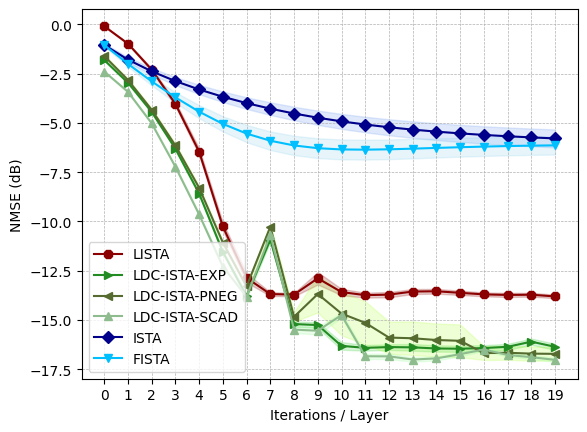

In [15]:
plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.2)

plt.plot(np.mean(LDC_LISTA_EXP_LOSS, axis = 0), label='LDC-ISTA-EXP', color='forestgreen', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(LDC_LISTA_EXP_LOSS, axis = 0) - (2/np.sqrt(LDC_LISTA_EXP_LOSS.shape[1])) * np.std(LDC_LISTA_EXP_LOSS, axis = 0), 
                    np.mean(LDC_LISTA_EXP_LOSS, axis = 0) + (2/np.sqrt(LDC_LISTA_EXP_LOSS.shape[1])) * np.std(LDC_LISTA_EXP_LOSS, axis = 0), 
                    color='limegreen', 
                    alpha=0.2)

plt.plot(np.mean(LDC_LISTA_PNEG_LOSS, axis = 0), label='LDC-ISTA-PNEG', color='darkolivegreen', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(LDC_LISTA_PNEG_LOSS, axis = 0) - (2/np.sqrt(LDC_LISTA_PNEG_LOSS.shape[1])) * np.std(LDC_LISTA_PNEG_LOSS, axis = 0), 
                    np.mean(LDC_LISTA_PNEG_LOSS, axis = 0) + (2/np.sqrt(LDC_LISTA_PNEG_LOSS.shape[1])) * np.std(LDC_LISTA_PNEG_LOSS, axis = 0), 
                    color='greenyellow', 
                    alpha=0.2)

plt.plot(np.mean(LDC_LISTA_SCAD_LOSS, axis = 0), label='LDC-ISTA-SCAD', color='darkseagreen', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(LDC_LISTA_SCAD_LOSS, axis = 0) - (2/np.sqrt(LDC_LISTA_SCAD_LOSS.shape[1])) * np.std(LDC_LISTA_SCAD_LOSS, axis = 0), 
                    np.mean(LDC_LISTA_SCAD_LOSS, axis = 0) + (2/np.sqrt(LDC_LISTA_SCAD_LOSS.shape[1])) * np.std(LDC_LISTA_SCAD_LOSS, axis = 0), 
                    color='palegreen', 
                    alpha=0.2)

plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.xticks(range(LAYERS))

plt.ylabel('NMSE (dB)')
plt.xlabel('Iterations / Layer')

#plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

In [16]:
exp_3 = {
    'LISTA':LISTA_LOSS,
    'LDC-LISTA-EXP':LDC_LISTA_EXP_LOSS,
    'LDC-LISTA-PNEG':LDC_LISTA_PNEG_LOSS,
    'LDC-LISTA-SCAD':LDC_LISTA_SCAD_LOSS,
    'ISTA':ISTA_LOSS,
    'FISTA':FISTA_LOSS
}

with open('LDC-LISTA_3.pkl', 'wb') as handle:
    pickle.dump(exp_3, handle, protocol=pickle.HIGHEST_PROTOCOL)

_________

In [307]:
class TiLDC_ISTA(nn.Module):
    def __init__(self, A, mode, lambd=0.1, p =0.012, p_max = 0.12, T = 5):
        super().__init__()
    
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        assert mode in ['EXP', 'PNEG', 'SCAD']

        self.mode = mode

        self.A = A.to(self.device)  # Move A to the correct device
        self.A.requires_grad = False

        self.T = T

        self.L = torch.max(torch.real(torch.linalg.eigvals(A.t() @ A))).to(self.device)

        # Initialization of the learnable parameters
        self.theta = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device), requires_grad=True)
        self.mu = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) / self.L, requires_grad=True)
        self.lambd = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) * lambd, requires_grad=True)
        
        # Linear layers
        self.W = nn.Linear(A.shape[1], A.shape[0], bias=False).to(self.device)
        self.W.weight.data = torch.clone(self.A.T).to(self.device)

        # Support selection mechanism parameters
        self.p = p
        self.p_max = p_max

        # Losses when doing inference (placeholder for NMSE accumulation)
        self.losses = torch.zeros(self.T, device=self.device)
        self.est_powers = torch.zeros(self.T, device=self.device)

        # Mode setting for the layer
        if mode == 'EXP':
            self.ddx = self.ddxEXP
            self.eta = self.etaEXP

        if mode == 'PNEG':
            self.P = - nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) *0.1, requires_grad=True)
            self.ddx = self.ddxNEG
            self.eta = self.etaNEG

        if mode == 'SCAD':
            self.a = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) * 2, requires_grad=True)
            self.ddx = self.ddxSCAD
            self.eta = self.etaSCAD

    #_________________________________________________________________
    #______________ METHODS FOR ENABLING DIFFERENT LAYERS_____________
    #_________________________________________________________________
    
    # Derivatives of the nonconvex components
    def ddxEXP(self, x, t):
        return torch.sign(x) * self.theta[t,:,:] * (1 - torch.exp(-self.theta[t,:,:] * torch.abs(x)))

    def ddxNEG(self, x, t):
        return -torch.sign(x) * self.P[t,:,:] * self.theta[t,:,:] * (1 - (1 + self.theta[t,:,:] * torch.abs(x)) ** (self.P[t,:,:] - 1))

    def ddxSCAD(self, x, t):
        abs_x = torch.abs(x)

        mask1 = (abs_x <= 1)
        mask2 = (1 / self.theta[t,:,:] < abs_x) & (abs_x <= self.a[t,:,:] / self.theta[t,:,:])
        mask3 = (abs_x > self.a[t,:,:] / self.theta[t,:,:])

        # Compute the value for each condition
        val1 = torch.zeros_like(x)
        val2 = torch.sign(x) * (2 * self.theta[t,:,:] * (self.theta[t,:,:] * abs_x - 1)) / (self.a[t,:,:] ** 2 - 1)
        val3 = torch.sign(x) * (2 * self.theta[t,:,:] / (self.a[t,:,:] + 1))

        # Apply the masks to compute the final result
        result = torch.where(mask1, val1, torch.where(mask2, val2, val3))

        return result

    # Parametrization for the surrogates
    def etaEXP(self, t):
        return self.theta[t,:,:]

    def etaNEG(self, t):
        return -self.P[t,:,:] * self.theta[t,:,:]

    def etaSCAD(self, t):
        return 2 * self.theta[t,:,:] / (self.a[t,:,:] + 1)
    
    #___________________________________________________________________
    #___________________________________________________________________
        
    def _shrink(self, x, beta, t):
        # Get the absolute values of the elements in x
        abs_x = torch.abs(x)
        
        # Sort the elements of x by magnitude along the last dimension (num_features)
        sorted_abs_x, _ = torch.sort(abs_x, dim=-1, descending=True)

        # Determine the threshold index corresponding to the top p% elements in each sample
        p = torch.min(torch.tensor([self.p * t, self.p_max], device=self.device))
        threshold_idx = int(p * x.shape[-1])
        
        # Get the magnitude threshold for the top p% of elements (per batch)
        if threshold_idx > 0:
            threshold_value = sorted_abs_x[:, threshold_idx - 1:threshold_idx]  # Shape: (batch_size, 1)
        else:
            threshold_value = torch.zeros(x.shape[0], 1, device=x.device)  # Shape: (batch_size, 1)

        # Create a mask to exclude the top p% of elements from shrinkage
        mask = abs_x >= threshold_value
        
        # Apply soft thresholding only to elements outside the top p%
        x_shrink = beta * F.softshrink(x / beta, lambd=1)
        
        # Return the original values for the top p% and the shrinked values for others
        return torch.where(mask, x, x_shrink)

    
    def forward(self, y, S=None):     
        # Move inputs to the correct device
        y = y.to(self.device)
        if S is not None:
            S = S.to(self.device)

        # Initial sparse estimate using the first layer
        x = self._shrink(self.mu[0, :, :] * self.W(y), self.eta(0) * self.lambd[0,:,:] * self.mu[0,:,:], 0)
        
        # Loop over layers to refine the estimate
        for t in range(1, self.T + 1):
            x = self._shrink(x - self.mu[t, :, :] * (self.W(torch.matmul(x, self.A.t()) - y)) + self.lambd[t,:,:] * self.mu[t,:,:] * self.ddx(x, t), 
                             self.eta(t) * self.lambd[t,:,:] * self.mu[t,:,:],
                             t)
            
            if S is not None:  # During inference, compute the NMSE at each layer
                with torch.no_grad():
                    mse_loss = F.mse_loss(x.detach(), S.detach(), reduction="sum")
                    signal_power = torch.sum(S.detach() ** 2)

                    self.losses[t - 1] += mse_loss.item()
                    self.est_powers[t - 1] += signal_power.item() + 1e-6

        return x

    # Method to compute NMSE during inference mode
    def compute_nmse_inference(self, test_loader):
        # Reset the losses accumulator
        self.losses = torch.zeros(self.T, device=self.device)
        
        # Iterate over test_loader
        for _, (Y, S) in enumerate(test_loader):
            Y, S = Y.to(self.device), S.to(self.device)
            _ = self.forward(Y, S)  # This will accumulate NMSE values
        
        # Convert accumulated NMSE to dB
        nmse_db = 10 * torch.log10(self.losses / self.est_powers)
        
        # Reset the losses after inference
        self.losses = torch.zeros(self.T, device=self.device)
        self.est_powers = torch.zeros(self.T, device=self.device)

        # Return NMSE in dB for each layer
        return nmse_db

In [36]:
M = 10
LAYERS = 5
BETA_INIT = 0.4
EPOCHS = 50
SNR = None

TiLISTA_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_EXP_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_PNEG_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_SCAD_LOSS = torch.zeros((M, LAYERS))

ISTA_LOSS = torch.zeros((M, LAYERS))
FISTA_LOSS = torch.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 200
    m_ = 150
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = TiLISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = TiLDC_ISTA(torch.clone(A_), 'EXP', BETA_INIT, T = LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = TiLDC_ISTA(torch.clone(A_), 'PNEG', BETA_INIT, T = LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = TiLDC_ISTA(torch.clone(A_), 'SCAD', BETA_INIT, T = LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    TiLISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_EXP_LOSS[m,:] = model2.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_PNEG_LOSS[m,:] = model3.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_SCAD_LOSS[m,:] = model4.compute_nmse_inference(test_set).cpu()

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT).cpu()
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT).cpu()

100%|██████████| 10/10 [08:42<00:00, 52.26s/it]


In [38]:
TiLISTA_LOSS = TiLISTA_LOSS.cpu().numpy()
TiLDC_LISTA_EXP_LOSS = TiLDC_LISTA_EXP_LOSS.cpu().numpy()
TiLDC_LISTA_PNEG_LOSS = TiLDC_LISTA_PNEG_LOSS.cpu().numpy()
TiLDC_LISTA_SCAD_LOSS = TiLDC_LISTA_SCAD_LOSS.cpu().numpy()

ISTA_LOSS = ISTA_LOSS.cpu().numpy()
FISTA_LOSS = FISTA_LOSS.cpu().numpy()

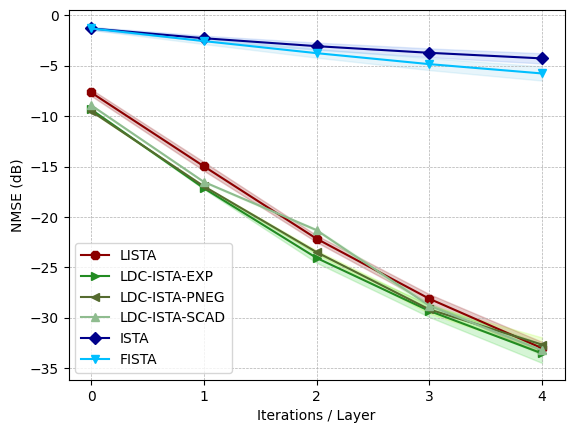

In [40]:
TiLISTA_LOSS = TiLISTA_LOSS.cpu().numpy()
TiLDC_LISTA_EXP_LOSS = TiLDC_LISTA_EXP_LOSS.cpu().numpy()
TiLDC_LISTA_PNEG_LOSS = TiLDC_LISTA_PNEG_LOSS.cpu().numpy()
TiLDC_LISTA_SCAD_LOSS = TiLDC_LISTA_SCAD_LOSS.cpu().numpy()

ISTA_LOSS = ISTA_LOSS.cpu().numpy()
FISTA_LOSS = FISTA_LOSS.cpu().numpy()

plt.plot(np.mean(TiLISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLISTA_LOSS, axis = 0) - (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    np.mean(TiLISTA_LOSS, axis = 0) + (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0), label='LDC-ISTA-EXP', color='forestgreen', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_EXP_LOSS.shape[1])) * np.std(TiLDC_LISTA_EXP_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_EXP_LOSS.shape[1])) * np.std(TiLDC_LISTA_EXP_LOSS, axis = 0), 
                    color='limegreen', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0), label='LDC-ISTA-PNEG', color='darkolivegreen', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_PNEG_LOSS.shape[1])) * np.std(TiLDC_LISTA_PNEG_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_PNEG_LOSS.shape[1])) * np.std(TiLDC_LISTA_PNEG_LOSS, axis = 0), 
                    color='greenyellow', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0), label='LDC-ISTA-SCAD', color='darkseagreen', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_SCAD_LOSS.shape[1])) * np.std(TiLDC_LISTA_SCAD_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_SCAD_LOSS.shape[1])) * np.std(TiLDC_LISTA_SCAD_LOSS, axis = 0), 
                    color='palegreen', 
                    alpha=0.2)

plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.xticks(range(LAYERS))

plt.ylabel('NMSE (dB)')
plt.xlabel('Iterations / Layer')


plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

In [42]:
M = 10
LAYERS = 16
BETA_INIT = 0.4
EPOCHS = 50
SNR = 1000

TiLISTA_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_EXP_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_PNEG_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_SCAD_LOSS = torch.zeros((M, LAYERS))

ISTA_LOSS = torch.zeros((M, LAYERS))
FISTA_LOSS = torch.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 500
    m_ = 250
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = TiLISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = TiLDC_ISTA(torch.clone(A_), 'EXP', BETA_INIT, T = LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = TiLDC_ISTA(torch.clone(A_), 'PNEG', BETA_INIT, T = LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = TiLDC_ISTA(torch.clone(A_), 'SCAD', BETA_INIT, T = LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    TiLISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_EXP_LOSS[m,:] = model2.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_PNEG_LOSS[m,:] = model3.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_SCAD_LOSS[m,:] = model4.compute_nmse_inference(test_set).cpu()

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT).cpu()
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT).cpu()

100%|██████████| 10/10 [22:08<00:00, 132.85s/it]


In [43]:
TiLISTA_LOSS = TiLISTA_LOSS.cpu().numpy()
TiLDC_LISTA_EXP_LOSS = TiLDC_LISTA_EXP_LOSS.cpu().numpy()
TiLDC_LISTA_PNEG_LOSS = TiLDC_LISTA_PNEG_LOSS.cpu().numpy()
TiLDC_LISTA_SCAD_LOSS = TiLDC_LISTA_SCAD_LOSS.cpu().numpy()

ISTA_LOSS = ISTA_LOSS.cpu().numpy()
FISTA_LOSS = FISTA_LOSS.cpu().numpy()

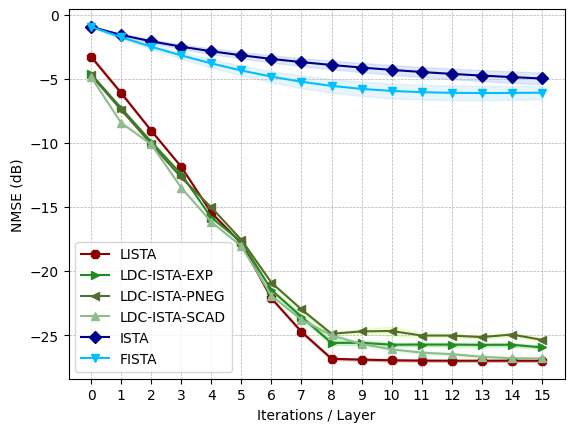

In [44]:
plt.plot(np.mean(TiLISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLISTA_LOSS, axis = 0) - (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    np.mean(TiLISTA_LOSS, axis = 0) + (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0), label='LDC-ISTA-EXP', color='forestgreen', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_EXP_LOSS.shape[1])) * np.std(TiLDC_LISTA_EXP_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_EXP_LOSS.shape[1])) * np.std(TiLDC_LISTA_EXP_LOSS, axis = 0), 
                    color='limegreen', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0), label='LDC-ISTA-PNEG', color='darkolivegreen', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_PNEG_LOSS.shape[1])) * np.std(TiLDC_LISTA_PNEG_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_PNEG_LOSS.shape[1])) * np.std(TiLDC_LISTA_PNEG_LOSS, axis = 0), 
                    color='greenyellow', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0), label='LDC-ISTA-SCAD', color='darkseagreen', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_SCAD_LOSS.shape[1])) * np.std(TiLDC_LISTA_SCAD_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_SCAD_LOSS.shape[1])) * np.std(TiLDC_LISTA_SCAD_LOSS, axis = 0), 
                    color='palegreen', 
                    alpha=0.2)

plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.xticks(range(LAYERS))

plt.ylabel('NMSE (dB)')
plt.xlabel('Iterations / Layer')


plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

________

In [316]:
class TiLDC_ISTA(nn.Module):
    def __init__(self, A, mode, lambd=0.1, p =0.012, p_max = 0.12, T = 5):
        super().__init__()
    
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        assert mode in ['EXP', 'PNEG', 'SCAD']

        self.mode = mode

        self.A = A.to(self.device)  # Move A to the correct device
        self.A.requires_grad = False

        self.T = T

        self.L = torch.max(torch.real(torch.linalg.eigvals(A.t() @ A))).to(self.device)

        # Initialization of the learnable parameters
        self.mu = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) / self.L, requires_grad=True)
        self.lambd = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) * lambd, requires_grad=True)
        
        # Linear layers
        self.W = nn.Linear(A.shape[1], A.shape[0], bias=False).to(self.device)
        self.W.weight.data = torch.clone(self.A.T).to(self.device) 

        self.Z = torch.linalg.pinv(self.A.T).to(self.device) * lambd 

        # Support selection mechanism parameters
        self.p = p
        self.p_max = p_max

        # Losses when doing inference (placeholder for NMSE accumulation)
        self.losses = torch.zeros(self.T, device=self.device)
        self.est_powers = torch.zeros(self.T, device=self.device)

        # Mode setting for the layer
        if mode == 'EXP':
            self.theta = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) * lambd /self.L, requires_grad=True)
            self.ddx = self.ddxEXP
            self.eta = self.etaEXP

        if mode == 'PNEG':
            self.theta = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) * (-lambd /(0.1*self.L)), requires_grad=True)
            self.P = - nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) *0.1, requires_grad=True)
            self.ddx = self.ddxNEG
            self.eta = self.etaNEG

        if mode == 'SCAD':
            self.theta = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) * 1.5 * lambd / self.L, requires_grad=True)
            self.a = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) * 2, requires_grad=True)
            self.ddx = self.ddxSCAD
            self.eta = self.etaSCAD

    #_________________________________________________________________
    #______________ METHODS FOR ENABLING DIFFERENT LAYERS_____________
    #_________________________________________________________________
    
    # Derivatives of the nonconvex components
    def ddxEXP(self, x, t):
        return torch.sign(x) * self.theta[t,:,:] * (1 - torch.exp(-self.theta[t,:,:] * torch.abs(x)))

    def ddxNEG(self, x, t):
        return -torch.sign(x) * self.P[t,:,:] * self.theta[t,:,:] * (1 - (1 + self.theta[t,:,:] * torch.abs(x)) ** (self.P[t,:,:] - 1))

    def ddxSCAD(self, x, t):
        abs_x = torch.abs(x)

        mask1 = (abs_x <= 1)
        mask2 = (1 / self.theta[t,:,:] < abs_x) & (abs_x <= self.a[t,:,:] / self.theta[t,:,:])
        mask3 = (abs_x > self.a[t,:,:] / self.theta[t,:,:])

        # Compute the value for each condition
        val1 = torch.zeros_like(x)
        val2 = torch.sign(x) * (2 * self.theta[t,:,:] * (self.theta[t,:,:] * abs_x - 1)) / (self.a[t,:,:] ** 2 - 1)
        val3 = torch.sign(x) * (2 * self.theta[t,:,:] / (self.a[t,:,:] + 1))

        # Apply the masks to compute the final result
        result = torch.where(mask1, val1, torch.where(mask2, val2, val3))

        return result

    # Parametrization for the surrogates
    def etaEXP(self, t):
        return self.theta[t,:,:]

    def etaNEG(self, t):
        return -self.P[t,:,:] * self.theta[t,:,:]

    def etaSCAD(self, t):
        return 2 * self.theta[t,:,:] / (self.a[t,:,:] + 1)
    
    #___________________________________________________________________
    #___________________________________________________________________
        
    def _shrink(self, x, beta, t):
        # Get the absolute values of the elements in x
        abs_x = torch.abs(x)
        
        # Sort the elements of x by magnitude along the last dimension (num_features)
        sorted_abs_x, _ = torch.sort(abs_x, dim=-1, descending=True)

        # Determine the threshold index corresponding to the top p% elements in each sample
        p = torch.min(torch.tensor([self.p * t, self.p_max], device=self.device))
        threshold_idx = int(p * x.shape[-1])
        
        # Get the magnitude threshold for the top p% of elements (per batch)
        if threshold_idx > 0:
            threshold_value = sorted_abs_x[:, threshold_idx - 1:threshold_idx]  # Shape: (batch_size, 1)
        else:
            threshold_value = torch.zeros(x.shape[0], 1, device=x.device)  # Shape: (batch_size, 1)

        # Create a mask to exclude the top p% of elements from shrinkage
        mask = abs_x >= threshold_value
        
        # Apply soft thresholding only to elements outside the top p%
        x_shrink = beta * F.softshrink(x / beta, lambd=1)
        
        # Return the original values for the top p% and the shrinked values for others
        return torch.where(mask, x, x_shrink)

    
    def forward(self, y, S=None):     
        # Move inputs to the correct device
        y = y.to(self.device)
        if S is not None:
            S = S.to(self.device)

        # Initial sparse estimate using the first layer
        x = self._shrink(self.mu[0, :, :] * self.W(y), self.eta(0) * self.lambd[0,:,:] * self.mu[0,:,:], 0)
        
        # Loop over layers to refine the estimate
        for t in range(1, self.T + 1):
            x = self._shrink(x - self.mu[t, :, :] * self.W(
                torch.matmul(x, self.A.t()) - y + torch.matmul(self.ddx(x, t), self.Z.t())), 
                             self.eta(t) * self.lambd[t,:,:] * self.mu[t,:,:],
                             t)
            
            if S is not None:  # During inference, compute the NMSE at each layer
                with torch.no_grad():
                    mse_loss = F.mse_loss(x.detach(), S.detach(), reduction="sum")
                    signal_power = torch.sum(S.detach() ** 2)

                    self.losses[t - 1] += mse_loss.item()
                    self.est_powers[t - 1] += signal_power.item() + 1e-6

        return x

    # Method to compute NMSE during inference mode
    def compute_nmse_inference(self, test_loader):
        # Reset the losses accumulator
        self.losses = torch.zeros(self.T, device=self.device)
        
        # Iterate over test_loader
        for _, (Y, S) in enumerate(test_loader):
            Y, S = Y.to(self.device), S.to(self.device)
            _ = self.forward(Y, S)  # This will accumulate NMSE values
        
        # Convert accumulated NMSE to dB
        nmse_db = 10 * torch.log10(self.losses / self.est_powers)
        
        # Reset the losses after inference
        self.losses = torch.zeros(self.T, device=self.device)
        self.est_powers = torch.zeros(self.T, device=self.device)

        # Return NMSE in dB for each layer
        return nmse_db

In [ ]:
M = 10
LAYERS = 5
BETA_INIT = 0.4
EPOCHS = 50
SNR = None

TiLISTA_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_EXP_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_PNEG_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_SCAD_LOSS = torch.zeros((M, LAYERS))

ISTA_LOSS = torch.zeros((M, LAYERS))
FISTA_LOSS = torch.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 200
    m_ = 150
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = TiLISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = TiLDC_ISTA(torch.clone(A_), 'EXP', BETA_INIT, T = LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = TiLDC_ISTA(torch.clone(A_), 'PNEG', BETA_INIT, T = LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = TiLDC_ISTA(torch.clone(A_), 'SCAD', BETA_INIT, T = LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    TiLISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_EXP_LOSS[m,:] = model2.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_PNEG_LOSS[m,:] = model3.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_SCAD_LOSS[m,:] = model4.compute_nmse_inference(test_set).cpu()

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT).cpu()
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT).cpu()

In [ ]:
TiLISTA_LOSS = TiLISTA_LOSS.cpu().numpy()
TiLDC_LISTA_EXP_LOSS = TiLDC_LISTA_EXP_LOSS.cpu().numpy()
TiLDC_LISTA_PNEG_LOSS = TiLDC_LISTA_PNEG_LOSS.cpu().numpy()
TiLDC_LISTA_SCAD_LOSS = TiLDC_LISTA_SCAD_LOSS.cpu().numpy()

ISTA_LOSS = ISTA_LOSS.cpu().numpy()
FISTA_LOSS = FISTA_LOSS.cpu().numpy()

plt.plot(np.mean(TiLISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLISTA_LOSS, axis = 0) - (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    np.mean(TiLISTA_LOSS, axis = 0) + (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0), label='LDC-ISTA-EXP', color='forestgreen', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_EXP_LOSS.shape[1])) * np.std(TiLDC_LISTA_EXP_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_EXP_LOSS.shape[1])) * np.std(TiLDC_LISTA_EXP_LOSS, axis = 0), 
                    color='limegreen', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0), label='LDC-ISTA-PNEG', color='darkolivegreen', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_PNEG_LOSS.shape[1])) * np.std(TiLDC_LISTA_PNEG_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_PNEG_LOSS.shape[1])) * np.std(TiLDC_LISTA_PNEG_LOSS, axis = 0), 
                    color='greenyellow', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0), label='LDC-ISTA-SCAD', color='darkseagreen', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_SCAD_LOSS.shape[1])) * np.std(TiLDC_LISTA_SCAD_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_SCAD_LOSS.shape[1])) * np.std(TiLDC_LISTA_SCAD_LOSS, axis = 0), 
                    color='palegreen', 
                    alpha=0.2)

plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.xticks(range(LAYERS))

plt.ylabel('NMSE (dB)')
plt.xlabel('Iterations / Layer')


plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

In [299]:
M = 10
LAYERS = 16
BETA_INIT = 0.4
EPOCHS = 50
SNR = 1000

TiLISTA_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_EXP_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_PNEG_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_SCAD_LOSS = torch.zeros((M, LAYERS))

ISTA_LOSS = torch.zeros((M, LAYERS))
FISTA_LOSS = torch.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 500
    m_ = 250
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = TiLISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = TiLDC_ISTA(torch.clone(A_), 'EXP', BETA_INIT, T = LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = TiLDC_ISTA(torch.clone(A_), 'PNEG', BETA_INIT, T = LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = TiLDC_ISTA(torch.clone(A_), 'SCAD', BETA_INIT, T = LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    TiLISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_EXP_LOSS[m,:] = model2.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_PNEG_LOSS[m,:] = model3.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_SCAD_LOSS[m,:] = model4.compute_nmse_inference(test_set).cpu()

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT).cpu()
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT).cpu()

100%|██████████| 10/10 [20:52<00:00, 125.27s/it]


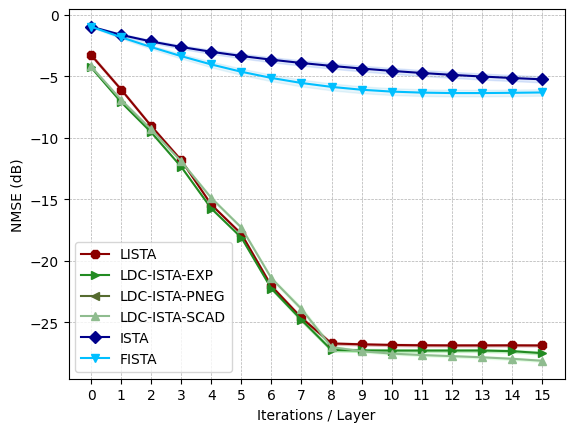

In [300]:
TiLISTA_LOSS = TiLISTA_LOSS.cpu().numpy()
TiLDC_LISTA_EXP_LOSS = TiLDC_LISTA_EXP_LOSS.cpu().numpy()
TiLDC_LISTA_PNEG_LOSS = TiLDC_LISTA_PNEG_LOSS.cpu().numpy()
TiLDC_LISTA_SCAD_LOSS = TiLDC_LISTA_SCAD_LOSS.cpu().numpy()

ISTA_LOSS = ISTA_LOSS.cpu().numpy()
FISTA_LOSS = FISTA_LOSS.cpu().numpy()

plt.plot(np.mean(TiLISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLISTA_LOSS, axis = 0) - (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    np.mean(TiLISTA_LOSS, axis = 0) + (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0), label='LDC-ISTA-EXP', color='forestgreen', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_EXP_LOSS.shape[1])) * np.std(TiLDC_LISTA_EXP_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_EXP_LOSS.shape[1])) * np.std(TiLDC_LISTA_EXP_LOSS, axis = 0), 
                    color='limegreen', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0), label='LDC-ISTA-PNEG', color='darkolivegreen', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_PNEG_LOSS.shape[1])) * np.std(TiLDC_LISTA_PNEG_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_PNEG_LOSS.shape[1])) * np.std(TiLDC_LISTA_PNEG_LOSS, axis = 0), 
                    color='greenyellow', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0), label='LDC-ISTA-SCAD', color='darkseagreen', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_SCAD_LOSS.shape[1])) * np.std(TiLDC_LISTA_SCAD_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_SCAD_LOSS.shape[1])) * np.std(TiLDC_LISTA_SCAD_LOSS, axis = 0), 
                    color='palegreen', 
                    alpha=0.2)

plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.xticks(range(LAYERS))

plt.ylabel('NMSE (dB)')
plt.xlabel('Iterations / Layer')


plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

In [309]:
M = 10
LAYERS = 20
BETA_INIT = 0.4
EPOCHS = 50
SNR = 1000

TiLISTA_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_EXP_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_PNEG_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_SCAD_LOSS = torch.zeros((M, LAYERS))

ISTA_LOSS = torch.zeros((M, LAYERS))
FISTA_LOSS = torch.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 500
    m_ = 300
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = TiLISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = TiLDC_ISTA(torch.clone(A_), 'EXP', BETA_INIT, T = LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = TiLDC_ISTA(torch.clone(A_), 'PNEG', BETA_INIT, T = LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = TiLDC_ISTA(torch.clone(A_), 'SCAD', BETA_INIT, T = LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    TiLISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_EXP_LOSS[m,:] = model2.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_PNEG_LOSS[m,:] = model3.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_SCAD_LOSS[m,:] = model4.compute_nmse_inference(test_set).cpu()

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT).cpu()
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT).cpu()

100%|██████████| 10/10 [26:43<00:00, 160.30s/it]


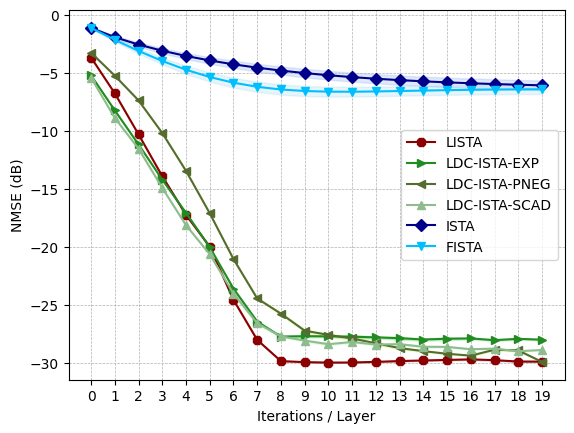

In [310]:
TiLISTA_LOSS = TiLISTA_LOSS.cpu().numpy()
TiLDC_LISTA_EXP_LOSS = TiLDC_LISTA_EXP_LOSS.cpu().numpy()
TiLDC_LISTA_PNEG_LOSS = TiLDC_LISTA_PNEG_LOSS.cpu().numpy()
TiLDC_LISTA_SCAD_LOSS = TiLDC_LISTA_SCAD_LOSS.cpu().numpy()

ISTA_LOSS = ISTA_LOSS.cpu().numpy()
FISTA_LOSS = FISTA_LOSS.cpu().numpy()

plt.plot(np.mean(TiLISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLISTA_LOSS, axis = 0) - (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    np.mean(TiLISTA_LOSS, axis = 0) + (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0), label='LDC-ISTA-EXP', color='forestgreen', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_EXP_LOSS.shape[1])) * np.std(TiLDC_LISTA_EXP_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_EXP_LOSS.shape[1])) * np.std(TiLDC_LISTA_EXP_LOSS, axis = 0), 
                    color='limegreen', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0), label='LDC-ISTA-PNEG', color='darkolivegreen', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_PNEG_LOSS.shape[1])) * np.std(TiLDC_LISTA_PNEG_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_PNEG_LOSS.shape[1])) * np.std(TiLDC_LISTA_PNEG_LOSS, axis = 0), 
                    color='greenyellow', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0), label='LDC-ISTA-SCAD', color='darkseagreen', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_SCAD_LOSS.shape[1])) * np.std(TiLDC_LISTA_SCAD_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_SCAD_LOSS.shape[1])) * np.std(TiLDC_LISTA_SCAD_LOSS, axis = 0), 
                    color='palegreen', 
                    alpha=0.2)

plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.xticks(range(LAYERS))

plt.ylabel('NMSE (dB)')
plt.xlabel('Iterations / Layer')


plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

In [38]:
torch.tensor(1.0).dtype

torch.float32

In [38]:
class ALDC_ISTA(nn.Module):
    def __init__(self, A, mode, lambd=0.1, p =0.012, p_max = 0.12, T = 5):
        super().__init__()
    
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        assert mode in ['EXP', 'PNEG', 'SCAD']

        self.mode = mode

        self.A = A.to(self.device)  # Move A to the correct device
        self.A.requires_grad = False

        self.T = T

        self.L = torch.max(torch.real(torch.linalg.eigvals(A.t() @ A))).to(self.device)

        # Initialization of the learnable parameters

        self.lambd = nn.ParameterList([
            nn.Parameter(torch.tensor(1).reshape(1, 1).to(self.device) * lambd / self.L, requires_grad=True)
            for _ in range(self.T + 1)
        ])

        self.mu = nn.ParameterList([
            nn.Parameter(torch.tensor(1).reshape(1, 1).to(self.device) / self.L, requires_grad=True)
            for _ in range(self.T + 1)
        ])

        self.theta = nn.ParameterList([
            nn.Parameter(torch.tensor(1.0).reshape(1, 1).to(self.device) * 5, requires_grad=True)
            for _ in range(self.T + 1)
            ])
        
        # Linear layer

        self.W = self.W_optimization().to(self.device)
        self.W1 = torch.clone((self.W.T @ self.A)).to(self.device)
        self.W2 = torch.clone(self.W.T).to(self.device)

        # Support selection mechanism parameters
        self.p = p
        self.p_max = p_max

        # Losses when doing inference (placeholder for NMSE accumulation)
        self.losses = torch.zeros(self.T, device=self.device)
        self.est_powers = torch.zeros(self.T, device=self.device)

        # Mode setting for the layer
        if mode == 'EXP':

            self.ddx = self.ddxEXP
            self.eta = self.etaEXP

        if mode == 'PNEG':

            self.P = nn.ParameterList([
            nn.Parameter(torch.tensor(1.0).reshape(1, 1).to(self.device) * (-0.1), requires_grad=True)
            for _ in range(self.T + 1)
            ])
            self.ddx = self.ddxNEG
            self.eta = self.etaNEG

        if mode == 'SCAD':
       
            self.a = nn.ParameterList([
            nn.Parameter(torch.tensor(1.0).reshape(1, 1).to(self.device)*10, requires_grad=True)
            for _ in range(self.T + 1)
            ])        
            self.ddx = self.ddxSCAD
            self.eta = self.etaSCAD
    
    #_________________________________________________________________
    #______________ METHODS FOR ENABLING DIFFERENT LAYERS_____________
    #_________________________________________________________________

    def W_optimization(self):
        N, M = self.A.shape
        W = cp.Variable((N, M))

        objective = cp.Minimize(cp.norm(W.T @ self.A.cpu().numpy(), 'fro'))
        constraints = [W[:, m].T @ self.A.cpu().numpy()[:, m] == 1 for m in range(M)]
        prob = cp.Problem(objective, constraints)

        prob.solve(solver=cp.MOSEK)
        print('Linear layer initialized minimizing coherence!')
        return torch.from_numpy(W.value).float()
    
    # Derivatives of the nonconvex components
    def ddxEXP(self, x, t):
        return torch.sign(x) * self.theta[t] * (1 - torch.exp(-self.theta[t] * torch.abs(x)))

    def ddxNEG(self, x, t):
        return -torch.sign(x) * self.P[t] * self.theta[t] * (1 - (1 + self.theta[t] * torch.abs(x)) ** (self.P[t] - 1))

    def ddxSCAD(self, x, t):
        abs_x = torch.abs(x)

        mask1 = (abs_x <= 1)
        mask2 = (1 / self.theta[t] < abs_x) & (abs_x <= self.a[t] / self.theta[t])
        mask3 = (abs_x > self.a[t] / self.theta[t])

        # Compute the value for each condition
        val1 = torch.zeros_like(x)
        val2 = torch.sign(x) * (2 * self.theta[t] * (self.theta[t] * abs_x - 1)) / (self.a[t] ** 2 - 1)
        val3 = torch.sign(x) * (2 * self.theta[t] / (self.a[t] + 1))

        # Apply the masks to compute the final result
        result = torch.where(mask1, val1, torch.where(mask2, val2, val3))

        return result

    # Parametrization for the surrogates
    def etaEXP(self, t):
        return self.theta[t]

    def etaNEG(self, t):
        return -self.P[t] * self.theta[t]

    def etaSCAD(self, t):
        return 2 * self.theta[t] / (self.a[t] + 1)
    
    #___________________________________________________________________
    #___________________________________________________________________
        
    def _shrink(self, x, beta, t):
        # Get the absolute values of the elements in x
        abs_x = torch.abs(x)
        
        # Sort the elements of x by magnitude along the last dimension (num_features)
        sorted_abs_x, _ = torch.sort(abs_x, dim=-1, descending=True)

        # Determine the threshold index corresponding to the top p% elements in each sample
        p = torch.min(torch.tensor([self.p * t, self.p_max], device=self.device))
        threshold_idx = int(p * x.shape[-1])
        
        # Get the magnitude threshold for the top p% of elements (per batch)
        if threshold_idx > 0:
            threshold_value = sorted_abs_x[:, threshold_idx - 1:threshold_idx]  # Shape: (batch_size, 1)
        else:
            threshold_value = torch.zeros(x.shape[0], 1, device=x.device)  # Shape: (batch_size, 1)

        # Create a mask to exclude the top p% of elements from shrinkage
        mask = abs_x >= threshold_value
        
        # Apply soft thresholding only to elements outside the top p%
        x_shrink = beta * F.softshrink(x / beta, lambd=1)
        
        # Return the original values for the top p% and the shrinked values for others
        return torch.where(mask, x, x_shrink)

    
    def forward(self, y, its=None, S=None):     
        # Move inputs to the correct device
        if its is None:
            its = self.T
            
        y = y.to(self.device)
        if S is not None:
            S = S.to(self.device)

        # Initial sparse estimate using the first layer
        x = torch.zeros((y.shape[0], self.A.shape[1])).to(self.device)
        x = self._shrink(self.mu[0] * torch.matmul(y, self.W2.t()) + self.lambd[0] * self.ddx(x, 0) , self.eta(0) * self.lambd[0], 1)
        
        # Loop over layers to refine the estimate
        for t in range(1, its + 1):
            x = self._shrink(x - self.mu[t] * (torch.matmul(x, self.W1.t()) - torch.matmul(y, self.W2.t())) + self.lambd[t] * self.ddx(x, t), 
                             self.eta(t) * self.lambd[t],
                             t)
            
            if S is not None:  # During inference, compute the NMSE at each layer
                with torch.no_grad():
                    mse_loss = F.mse_loss(x.detach(), S.detach(), reduction="sum")
                    signal_power = torch.sum(S.detach() ** 2)

                    self.losses[t - 1] += mse_loss.item()
                    self.est_powers[t - 1] += signal_power.item() + 1e-6

        return x

    # Method to compute NMSE during inference mode
    def compute_nmse_inference(self, test_loader):
        # Reset the losses accumulator
        self.losses = torch.zeros(self.T, device=self.device)
        
        # Iterate over test_loader
        for _, (Y, S) in enumerate(test_loader):
            Y, S = Y.to(self.device), S.to(self.device)
            _ = self.forward(y = Y, its = None, S = S)  # This will accumulate NMSE values
        
        # Convert accumulated NMSE to dB
        nmse_db = 10 * torch.log10(self.losses / self.est_powers)
        
        # Reset the losses after inference
        self.losses = torch.zeros(self.T, device=self.device)
        self.est_powers = torch.zeros(self.T, device=self.device)

        # Return NMSE in dB for each layer
        return nmse_db

In [45]:
n_ = 500
m_ = 250
p_ = 0.1

# Sensing matrix

A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
A_ /= torch.linalg.norm(A_, dim = 0)

# Building a training set and a test set 
train_set = SyntheticSignals(
    A = A_,
    n = n_,        
    m = m_,
    p = p_,
    SNR = None,
    size = 10000,
    batch_size = 1000
    ).set_loader()

test_set = SyntheticSignals(
    A = A_,
    n = n_,        
    m = m_,
    p = p_,
    SNR = None,
    size = 1000
    ).set_loader()

In [46]:
model = ALDC_ISTA(torch.clone(A_), 'SCAD', 0.4, T = 16)

Linear layer initialized minimizing coherence!


In [6]:
import torch.optim as optim

def layerwise_train_DC(
        model, 
        train_loader, 
        valid_loader, 
        model_class,
        DCSIP,
        lr=5e-4, 
        ft_lr=3e-5,
        num_epochs=100, 
        verbose=True, 
        clip_value=10.0, 
        eps=1e-6, 
        fine_tune_epochs=100, 
        patience=10):

    assert model_class in [
        'L-DC-ISTA',
        'LISTA-DC-CPSS',
        'TIL-DC-ISTA',
        'AL-DC-ISTA'
    ]

    assert DCSIP in [
        'EXP',
        'PNEG',
        'SCAD'
    ]

    device = model.device
    model = model.to(device)

    linear_shared = True

    loss_train_all = {}
    loss_test_all = {}

    T = model.T  # Number of layers/iterations

    for t in range(T+1):

        if verbose:
            print(f"===== Training Layer {t+1}/{T} =====")

        # Freeze parameters beyond current layer t
        for layer_idx in range(t):
            model.lambd[layer_idx].requires_grad = False
            if model_class != 'LISTA' and linear_shared == True:
                model.mu[layer_idx].requires_grad = False
                model.theta[layer_idx].requires_grad = False
                if DCSIP == 'SCAD':
                    model.a[layer_idx].requires_grad = False
                if DCSIP == 'PNEG':
                    model.P[layer_idx].requires_grad = False

            if not linear_shared:
                if model_class == 'LISTA':
                    model.Ws_1[layer_idx].weight.requires_grad = False
                    model.Ws_2[layer_idx].weight.requires_grad = False
                if model_class == 'LISTA-CPSS':
                    model.Ws[layer_idx].weight.requires_grad = False            


        # Define optimizer to include W1, W2, and parameters up to layer t
        if model_class == 'LISTA':
            if not linear_shared:
                optimizer = optim.Adam(
                    list(model.Ws_1.parameters())[:t+1] + 
                    list(model.Ws_2.parameters())[:t+1] + 
                    list(model.beta)[:t+1],
                    lr=lr,
                    eps=eps
                )
            else:
                optimizer = optim.Adam(
                    list(model.Ws_1.parameters()) + 
                    list(model.Ws_2.parameters()) + 
                    list(model.beta)[:t+1] + 
                    list(model.mu)[:t+1],
                    lr=lr,
                    eps=eps
                )

        if model_class == 'LISTA-CPSS':
            optimizer = optim.Adam(
                list(model.Ws.parameters())[:t+1] +
                list(model.beta)[:t+1],
                lr=lr,
                eps=eps
            )

        if model_class == 'TILISTA':
            optimizer = optim.Adam(
                list(model.W.parameters()) +
                list(model.beta)[:t+1] + 
                list(model.mu)[:t+1],
                lr=lr,
                eps=eps
            )

        if model_class == 'AL-DC-ISTA':
            params = list(model.lambd)[:t+1] + list(model.theta)[:t+1] + list(model.mu)[:t+1]
            if DCSIP == 'PNEG':
                params += list(model.P)[:t+1]
            if DCSIP == 'SCAD':
                params += list(model.a)[:t+1]
            optimizer = optim.Adam(
                params,
                lr=lr,
                eps=eps
            )

        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

        # Initialize loss tracking for current layer
        loss_train = np.zeros((num_epochs,))
        loss_test = np.zeros((num_epochs,))

        # Early stopping variables
        best_val_loss = float('inf')
        epochs_since_improvement = 0
        best_model_state = None

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            signal_power_train = 0.0

            for Y, S in train_loader:
                Y = Y.to(device)
                S = S.to(device)

                optimizer.zero_grad()
                S_hat = model(y=Y, its=t, S = None)

                mse_loss = F.mse_loss(S_hat, S, reduction="sum")
                signal_power = torch.sum(S ** 2)

                loss = mse_loss
                loss.backward()

                # Apply gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

                optimizer.step()

                train_loss += mse_loss.item()
                signal_power_train += signal_power.item()

            # Compute NMSE in dB for training set
            nmse_train = train_loss / (signal_power_train + eps)
            loss_train[epoch] = 10 * np.log10(nmse_train + eps)
            scheduler.step()

            # Validation
            model.eval()
            test_loss_epoch = 0.0
            signal_power_test = 0.0

            with torch.no_grad():
                for Y, S in valid_loader:
                    Y = Y.to(device)
                    S = S.to(device)

                    S_hat = model(Y, its=t)

                    mse_loss = F.mse_loss(S_hat, S, reduction="sum")
                    signal_power = torch.sum(S ** 2)

                    test_loss_epoch += mse_loss.item()
                    signal_power_test += signal_power.item()

            nmse_test = test_loss_epoch / (signal_power_test + eps)
            loss_test[epoch] = 10 * np.log10(nmse_test + eps)

            if verbose and (epoch % 10 == 0 or epoch == num_epochs - 1):
                print(
                    f"Layer {t+1}, Epoch {epoch+1}/{num_epochs}, "
                    f"Train NMSE (dB): {loss_train[epoch]:.6f}, "
                    f"Validation NMSE (dB): {loss_test[epoch]:.6f}"
                )

            # Early stopping check
            if loss_test[epoch] < best_val_loss:
                best_val_loss = loss_test[epoch]
                epochs_since_improvement = 0
                best_model_state = model.state_dict()  # Save the best model state
            else:
                epochs_since_improvement += 1

            if epochs_since_improvement >= patience:
                if verbose:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                model.load_state_dict(best_model_state)  # Restore best model state
                break

        # Store losses for current layer
        loss_train_all[f"Layer_{t+1}"] = loss_train[:epoch+1]
        loss_test_all[f"Layer_{t+1}"] = loss_test[:epoch+1]

        if verbose:
            print(f"===== Finished Training Layer {t+1}/{T} =====\n")

        # Optionally, fine-tune the entire network
        if fine_tune_epochs > 0:
            if verbose:
                print("===== Fine-Tuning the Entire Network =====")

            # Unfreeze all parameters
            for layer_idx in range(t + 1):
                model.theta[layer_idx].requires_grad = True
                if model_class != 'LISTA' and linear_shared == True:
                    model.mu[layer_idx].requires_grad = True
                    model.lambd[layer_idx].requires_grad = True
                    if DCSIP == 'SCAD':
                        model.a[layer_idx].requires_grad = True
                    if DCSIP == 'PNEG':
                        model.P[layer_idx].requires_grad = True
                if not linear_shared:
                    if model_class == 'LISTA':
                        model.Ws_1[layer_idx].weight.requires_grad = True
                        model.Ws_2[layer_idx].weight.requires_grad = True
                    if model_class == 'LISTA-CPSS':
                        model.Ws[layer_idx].weight.requires_grad = True   

            if model_class == 'LISTA':
                if not linear_shared:
                    optimizer = optim.Adam(
                        list(model.Ws_1.parameters())[:t+1] + 
                        list(model.Ws_2.parameters())[:t+1] + 
                        list(model.beta)[:t+1],
                        lr=ft_lr,
                        eps=eps
                    )
                else:
                    optimizer = optim.Adam(
                        list(model.Ws_1.parameters()) + 
                        list(model.Ws_2.parameters()) + 
                        list(model.beta)[:t+1] + 
                        list(model.mu)[:t+1],
                        lr=ft_lr,
                        eps=eps
                    )

            if model_class == 'LISTA-CPSS':
                optimizer = optim.Adam(
                    list(model.Ws.parameters())[:t+1] +
                    list(model.beta)[:t+1],
                    lr=ft_lr,
                    eps=eps
                )

            if model_class == 'TILISTA':
                optimizer = optim.Adam(
                    list(model.W.parameters()) +
                    list(model.beta)[:t+1] + 
                    list(model.mu)[:t+1],
                    lr=ft_lr,
                    eps=eps
                )

            if model_class == 'AL-DC-ISTA':
                params = list(model.lambd)[:t+1] + list(model.theta)[:t+1] + list(model.mu)[:t+1]
                if DCSIP == 'PNEG':
                    params += list(model.P)[:t+1]
                if DCSIP == 'SCAD':
                    params += list(model.a)[:t+1]
                optimizer = optim.Adam(
                    params,
                    lr=lr,
                    eps=eps
                )

            scheduler_ft = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

            # Initialize loss tracking for fine-tuning
            loss_train_ft = np.zeros((fine_tune_epochs,))
            loss_test_ft = np.zeros((fine_tune_epochs,))

            best_val_loss_ft = float('inf')
            epochs_since_improvement_ft = 0
            best_model_state_ft = None

            for epoch in range(fine_tune_epochs):
                model.train()
                train_loss = 0.0
                signal_power_train = 0.0

                for Y, S in train_loader:
                    Y = Y.to(device)
                    S = S.to(device)

                    optimizer.zero_grad()
                    S_hat = model(Y, its=t)

                    mse_loss = F.mse_loss(S_hat, S, reduction="sum")
                    signal_power = torch.sum(S ** 2)

                    loss = mse_loss
                    loss.backward()

                    # Apply gradient clipping
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

                    optimizer.step()

                    train_loss += mse_loss.item()
                    signal_power_train += signal_power.item()

                # Compute NMSE in dB for training set
                nmse_train = train_loss / (signal_power_train + eps)
                loss_train_ft[epoch] = 10 * np.log10(nmse_train + eps)
                scheduler_ft.step()

                # Validation
                model.eval()
                test_loss_epoch = 0.0
                signal_power_test = 0.0

                with torch.no_grad():
                    for Y, S in valid_loader:
                        Y = Y.to(device)
                        S = S.to(device)

                        S_hat = model(Y, its=t)

                        mse_loss = F.mse_loss(S_hat, S, reduction="sum")
                        signal_power = torch.sum(S ** 2)

                        test_loss_epoch += mse_loss.item()
                        signal_power_test += signal_power.item()

                nmse_test = test_loss_epoch / (signal_power_test + eps)
                loss_test_ft[epoch] = 10 * np.log10(nmse_test + eps)

                if verbose and (epoch % 10 == 0 or epoch == fine_tune_epochs - 1):
                    print(
                        f"Fine-Tune Epoch {epoch+1}/{fine_tune_epochs}, "
                        f"Train NMSE (dB): {loss_train_ft[epoch]:.6f}, "
                        f"Validation NMSE (dB): {loss_test_ft[epoch]:.6f}"
                    )

                # Early stopping for fine-tuning
                if loss_test_ft[epoch] < best_val_loss_ft:
                    best_val_loss_ft = loss_test_ft[epoch]
                    epochs_since_improvement_ft = 0
                    best_model_state_ft = model.state_dict()  # Save the best model state
                else:
                    epochs_since_improvement_ft += 1

                if epochs_since_improvement_ft >= patience:
                    if verbose:
                        print(f"Early stopping for fine-tuning triggered after {epoch+1} epochs")
                    model.load_state_dict(best_model_state_ft)  # Restore best model state
                    break

            # Store fine-tuning losses
            loss_train_all["Fine_Tune"] = loss_train_ft[:epoch+1]
            loss_test_all["Fine_Tune"] = loss_test_ft[:epoch+1]

            if verbose:
                print("===== Finished Fine-Tuning =====\n")

    return loss_train_all, loss_test_all

In [47]:
layerwise_train_DC(model, train_set, test_set, 'AL-DC-ISTA', 'SCAD', lr = 3e-3, ft_lr = 3e-5)

===== Training Layer 1/16 =====
Layer 1, Epoch 1/100, Train NMSE (dB): -1.470782, Validation NMSE (dB): -1.672440
Layer 1, Epoch 11/100, Train NMSE (dB): -3.922607, Validation NMSE (dB): -4.042473
Layer 1, Epoch 21/100, Train NMSE (dB): -5.789668, Validation NMSE (dB): -5.852898
Layer 1, Epoch 31/100, Train NMSE (dB): -6.219081, Validation NMSE (dB): -6.216844
Layer 1, Epoch 41/100, Train NMSE (dB): -6.219029, Validation NMSE (dB): -6.216775
Layer 1, Epoch 51/100, Train NMSE (dB): -6.219066, Validation NMSE (dB): -6.216773
Early stopping triggered after 52 epochs
===== Finished Training Layer 1/16 =====

===== Fine-Tuning the Entire Network =====
Fine-Tune Epoch 1/100, Train NMSE (dB): -6.218822, Validation NMSE (dB): -6.216666
Fine-Tune Epoch 11/100, Train NMSE (dB): -6.218996, Validation NMSE (dB): -6.216871
Early stopping for fine-tuning triggered after 12 epochs
===== Finished Fine-Tuning =====

===== Training Layer 2/16 =====
Layer 2, Epoch 1/100, Train NMSE (dB): -6.922911, Valid

({'Layer_1': array([-1.47078221, -1.81057593, -2.0568761 , -2.28460022, -2.52806311,
         -2.76741873, -3.00259048, -3.2356249 , -3.46672152, -3.6963052 ,
         -3.92260679, -4.1448316 , -4.36243006, -4.57414551, -4.77888753,
         -4.97562735, -5.16285494, -5.33941373, -5.50380509, -5.65398788,
         -5.78966763, -5.90835945, -6.00937313, -6.09137259, -6.15366242,
         -6.19501464, -6.21562225, -6.21825425, -6.21829051, -6.21893031,
         -6.21908078, -6.21897847, -6.2189104 , -6.21875351, -6.21907706,
         -6.21905644, -6.2186263 , -6.21896885, -6.21895444, -6.21889475,
         -6.21902946, -6.21896832, -6.21886427, -6.21901505, -6.2189625 ,
         -6.21900239, -6.21907486, -6.21902432, -6.21850409, -6.2190559 ,
         -6.21906567, -6.2190826 ]),
  'Fine_Tune': array([-58.7685531 , -59.53790071, -59.65460465, -59.65251029,
         -59.73656422, -59.78328124, -59.71521671, -59.75949553,
         -59.74120696, -59.79049695, -59.75570968, -59.76097317,
    

In [48]:
model.compute_nmse_inference(test_set)[-1].cpu()

tensor(-71.6841)

In [170]:
model2 = ALISTA(torch.clone(A_), 0.4, T = 16)

Linear layer initialized minimizing coherence!


In [164]:
def layerwise_train(
        model, 
        train_loader, 
        valid_loader, 
        model_class,
        lr=5e-4, 
        ft_lr=3e-5,
        num_epochs=100, 
        verbose=True, 
        clip_value=10.0, 
        eps=1e-6, 
        fine_tune_epochs=100, 
        patience=10):

    assert model_class in [
        'LISTA',
        'LISTA-CPSS',
        'TILISTA',
        'ALISTA'
    ]

    device = model.device
    model = model.to(device)

    linear_shared = model.linear_shared

    loss_train_all = {}
    loss_test_all = {}

    T = model.T  # Number of layers/iterations

    for t in range(T+1):
        if verbose:
            print(f"===== Training Layer {t+1}/{T} =====")

        # Freeze parameters beyond current layer t
        for layer_idx in range(t):
            model.beta[layer_idx].requires_grad = False
            if model_class != 'LISTA' and linear_shared == True:
                model.mu[layer_idx].requires_grad = False
            if not linear_shared:
                if model_class == 'LISTA':
                    model.Ws_1[layer_idx].weight.requires_grad = False
                    model.Ws_2[layer_idx].weight.requires_grad = False
                if model_class == 'LISTA-CPSS':
                    model.Ws[layer_idx].weight.requires_grad = False            

        # Define optimizer to include W1, W2, and parameters up to layer t
        if model_class == 'LISTA':
            if not linear_shared:
                optimizer = optim.Adam(
                    list(model.Ws_1.parameters())[:t+1] + 
                    list(model.Ws_2.parameters())[:t+1] + 
                    list(model.beta)[:t+1],
                    lr=lr,
                    eps=eps
                )
            else:
                optimizer = optim.Adam(
                    list(model.Ws_1.parameters()) + 
                    list(model.Ws_2.parameters()) + 
                    list(model.beta)[:t+1] + 
                    list(model.mu)[:t+1],
                    lr=lr,
                    eps=eps
                )

        if model_class == 'LISTA-CPSS':
            optimizer = optim.Adam(
                list(model.Ws.parameters())[:t+1] +
                list(model.beta)[:t+1],
                lr=lr,
                eps=eps
            )

        if model_class == 'TILISTA':
            optimizer = optim.Adam(
                list(model.W.parameters()) +
                list(model.beta)[:t+1] + 
                list(model.mu)[:t+1],
                lr=lr,
                eps=eps
            )

        if model_class == 'ALISTA':
            optimizer = optim.Adam(
                list(model.beta)[:t+1] + 
                list(model.mu)[:t+1],
                lr=lr,
                eps=eps
            )

        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

        # Initialize loss tracking for current layer
        loss_train = np.zeros((num_epochs,))
        loss_test = np.zeros((num_epochs,))

        # Early stopping variables
        best_val_loss = float('inf')
        epochs_since_improvement = 0
        best_model_state = None

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            signal_power_train = 0.0

            for Y, S in train_loader:
                Y = Y.to(device)
                S = S.to(device)

                optimizer.zero_grad()
                S_hat = model(Y, its=t)

                mse_loss = F.mse_loss(S_hat, S, reduction="sum")
                signal_power = torch.sum(S ** 2)

                loss = mse_loss
                loss.backward()

                # Apply gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

                optimizer.step()

                train_loss += mse_loss.item()
                signal_power_train += signal_power.item()

            # Compute NMSE in dB for training set
            nmse_train = train_loss / (signal_power_train + eps)
            loss_train[epoch] = 10 * np.log10(nmse_train + eps)
            scheduler.step()

            # Validation
            model.eval()
            test_loss_epoch = 0.0
            signal_power_test = 0.0

            with torch.no_grad():
                for Y, S in valid_loader:
                    Y = Y.to(device)
                    S = S.to(device)

                    S_hat = model(Y, its=t)

                    mse_loss = F.mse_loss(S_hat, S, reduction="sum")
                    signal_power = torch.sum(S ** 2)

                    test_loss_epoch += mse_loss.item()
                    signal_power_test += signal_power.item()

            nmse_test = test_loss_epoch / (signal_power_test + eps)
            loss_test[epoch] = 10 * np.log10(nmse_test + eps)

            if verbose and (epoch % 10 == 0 or epoch == num_epochs - 1):
                print(
                    f"Layer {t+1}, Epoch {epoch+1}/{num_epochs}, "
                    f"Train NMSE (dB): {loss_train[epoch]:.6f}, "
                    f"Validation NMSE (dB): {loss_test[epoch]:.6f}"
                )

            # Early stopping check
            if loss_test[epoch] < best_val_loss:
                best_val_loss = loss_test[epoch]
                epochs_since_improvement = 0
                best_model_state = model.state_dict()  # Save the best model state
            else:
                epochs_since_improvement += 1

            if epochs_since_improvement >= patience:
                if verbose:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                model.load_state_dict(best_model_state)  # Restore best model state
                break

        # Store losses for current layer
        loss_train_all[f"Layer_{t+1}"] = loss_train[:epoch+1]
        loss_test_all[f"Layer_{t+1}"] = loss_test[:epoch+1]

        if verbose:
            print(f"===== Finished Training Layer {t+1}/{T} =====\n")

        # Optionally, fine-tune the entire network
        if fine_tune_epochs > 0:
            if verbose:
                print("===== Fine-Tuning the Entire Network =====")

            # Unfreeze all parameters
            for layer_idx in range(t + 1):
                model.beta[layer_idx].requires_grad = True
                if model_class != 'LISTA' and linear_shared == True:
                    model.mu[layer_idx].requires_grad = True
                if not linear_shared:
                    if model_class == 'LISTA':
                        model.Ws_1[layer_idx].weight.requires_grad = True
                        model.Ws_2[layer_idx].weight.requires_grad = True
                    if model_class == 'LISTA-CPSS':
                        model.Ws[layer_idx].weight.requires_grad = True   

            if model_class == 'LISTA':
                if not linear_shared:
                    optimizer = optim.Adam(
                        list(model.Ws_1.parameters())[:t+1] + 
                        list(model.Ws_2.parameters())[:t+1] + 
                        list(model.beta)[:t+1],
                        lr=ft_lr,
                        eps=eps
                    )
                else:
                    optimizer = optim.Adam(
                        list(model.Ws_1.parameters()) + 
                        list(model.Ws_2.parameters()) + 
                        list(model.beta)[:t+1] + 
                        list(model.mu)[:t+1],
                        lr=ft_lr,
                        eps=eps
                    )

            if model_class == 'LISTA-CPSS':
                optimizer = optim.Adam(
                    list(model.Ws.parameters())[:t+1] +
                    list(model.beta)[:t+1],
                    lr=ft_lr,
                    eps=eps
                )

            if model_class == 'TILISTA':
                optimizer = optim.Adam(
                    list(model.W.parameters()) +
                    list(model.beta)[:t+1] + 
                    list(model.mu)[:t+1],
                    lr=ft_lr,
                    eps=eps
                )

            if model_class == 'ALISTA':
                optimizer = optim.Adam(
                    list(model.beta)[:t+1] + 
                    list(model.mu)[:t+1],
                    lr=ft_lr,
                    eps=eps
                )

            scheduler_ft = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

            # Initialize loss tracking for fine-tuning
            loss_train_ft = np.zeros((fine_tune_epochs,))
            loss_test_ft = np.zeros((fine_tune_epochs,))

            best_val_loss_ft = float('inf')
            epochs_since_improvement_ft = 0
            best_model_state_ft = None

            for epoch in range(fine_tune_epochs):
                model.train()
                train_loss = 0.0
                signal_power_train = 0.0

                for Y, S in train_loader:
                    Y = Y.to(device)
                    S = S.to(device)

                    optimizer.zero_grad()
                    S_hat = model(Y, its=t)

                    mse_loss = F.mse_loss(S_hat, S, reduction="sum")
                    signal_power = torch.sum(S ** 2)

                    loss = mse_loss
                    loss.backward()

                    # Apply gradient clipping
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

                    optimizer.step()

                    train_loss += mse_loss.item()
                    signal_power_train += signal_power.item()

                # Compute NMSE in dB for training set
                nmse_train = train_loss / (signal_power_train + eps)
                loss_train_ft[epoch] = 10 * np.log10(nmse_train + eps)
                scheduler_ft.step()

                # Validation
                model.eval()
                test_loss_epoch = 0.0
                signal_power_test = 0.0

                with torch.no_grad():
                    for Y, S in valid_loader:
                        Y = Y.to(device)
                        S = S.to(device)

                        S_hat = model(Y, its=t)

                        mse_loss = F.mse_loss(S_hat, S, reduction="sum")
                        signal_power = torch.sum(S ** 2)

                        test_loss_epoch += mse_loss.item()
                        signal_power_test += signal_power.item()

                nmse_test = test_loss_epoch / (signal_power_test + eps)
                loss_test_ft[epoch] = 10 * np.log10(nmse_test + eps)

                if verbose and (epoch % 10 == 0 or epoch == fine_tune_epochs - 1):
                    print(
                        f"Fine-Tune Epoch {epoch+1}/{fine_tune_epochs}, "
                        f"Train NMSE (dB): {loss_train_ft[epoch]:.6f}, "
                        f"Validation NMSE (dB): {loss_test_ft[epoch]:.6f}"
                    )

                # Early stopping for fine-tuning
                if loss_test_ft[epoch] < best_val_loss_ft:
                    best_val_loss_ft = loss_test_ft[epoch]
                    epochs_since_improvement_ft = 0
                    best_model_state_ft = model.state_dict()  # Save the best model state
                else:
                    epochs_since_improvement_ft += 1

                if epochs_since_improvement_ft >= patience:
                    if verbose:
                        print(f"Early stopping for fine-tuning triggered after {epoch+1} epochs")
                    model.load_state_dict(best_model_state_ft)  # Restore best model state
                    break

            # Store fine-tuning losses
            loss_train_all["Fine_Tune"] = loss_train_ft[:epoch+1]
            loss_test_all["Fine_Tune"] = loss_test_ft[:epoch+1]

            if verbose:
                print("===== Finished Fine-Tuning =====\n")

    return loss_train_all, loss_test_all

In [171]:
layerwise_train(model2, train_set, test_set, 'ALISTA', lr = 3e-3, ft_lr = 3e-5)

===== Training Layer 1/16 =====
Layer 1, Epoch 1/100, Train NMSE (dB): -1.424022, Validation NMSE (dB): -1.633382
Layer 1, Epoch 11/100, Train NMSE (dB): -3.905359, Validation NMSE (dB): -4.019544
Layer 1, Epoch 21/100, Train NMSE (dB): -5.782291, Validation NMSE (dB): -5.835913
Layer 1, Epoch 31/100, Train NMSE (dB): -6.223689, Validation NMSE (dB): -6.209320
Layer 1, Epoch 41/100, Train NMSE (dB): -6.223953, Validation NMSE (dB): -6.209493
Early stopping triggered after 50 epochs
===== Finished Training Layer 1/16 =====

===== Fine-Tuning the Entire Network =====
Fine-Tune Epoch 1/100, Train NMSE (dB): -6.222848, Validation NMSE (dB): -6.208870
Fine-Tune Epoch 11/100, Train NMSE (dB): -6.223966, Validation NMSE (dB): -6.209515
Fine-Tune Epoch 21/100, Train NMSE (dB): -6.224019, Validation NMSE (dB): -6.209494
Early stopping for fine-tuning triggered after 21 epochs
===== Finished Fine-Tuning =====

===== Training Layer 2/16 =====
Layer 2, Epoch 1/100, Train NMSE (dB): -6.895934, Vali

({'Layer_1': array([-1.42402246, -1.77968769, -2.03069635, -2.25964844, -2.50548948,
         -2.74549427, -2.98153429, -3.21526789, -3.44761406, -3.67814538,
         -3.90535947, -4.12845398, -4.34663126, -4.55900366, -4.7646461 ,
         -4.96245331, -5.15047412, -5.32810469, -5.49338684, -5.6453349 ,
         -5.78229089, -5.90274093, -6.00528686, -6.08931447, -6.15343838,
         -6.19697677, -6.2194237 , -6.22251274, -6.22219959, -6.22360736,
         -6.22368888, -6.22390119, -6.22355983, -6.22392661, -6.223916  ,
         -6.22392399, -6.22400029, -6.22397419, -6.22400025, -6.22400586,
         -6.22395296, -6.22383928, -6.22385163, -6.22392643, -6.22381456,
         -6.22392413, -6.22398303, -6.22393968, -6.2236478 , -6.22351925]),
  'Fine_Tune': array([-57.74689864, -57.7493656 , -57.75164344, -57.75441181,
         -57.75627763, -57.75785485, -57.75998968, -57.76213188,
         -57.76427193, -57.76566181, -57.76841673, -57.77044178,
         -57.77232696, -57.77415175, -5

In [172]:
model2.compute_nmse_inference(test_set)

tensor([ -7.9949, -11.3335, -14.1636, -17.5738, -20.7830, -25.1252, -29.6864,
        -35.0528, -39.9037, -45.6084, -48.8130, -51.6654, -54.3458, -56.9199,
        -59.4318, -61.8914], device='cuda:0')

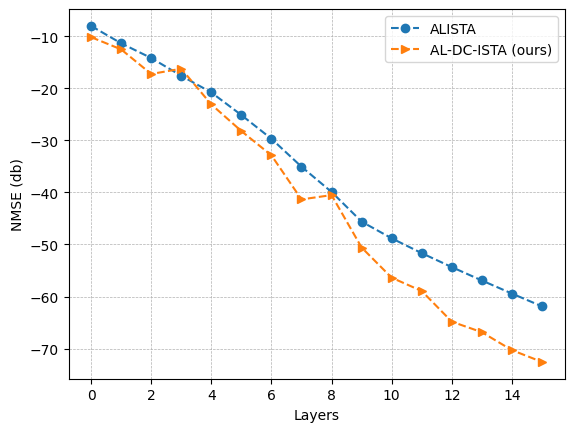

In [186]:
plt.plot(model2.compute_nmse_inference(test_set).cpu(), marker = 'o', linestyle='dashed', label = 'ALISTA')
plt.plot(model.compute_nmse_inference(test_set).cpu(), marker = '>', linestyle='dashed', label = 'AL-DC-ISTA (ours)')
plt.ylabel('NMSE (db)')
plt.xlabel('Layers')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)


In [17]:
def Conditioning(A, k = 1):
    U, S, Vh = torch.linalg.svd(A, full_matrices=False)
    S = torch.ones_like(S)
    S[-1] = 1/k

    return U @ torch.diag_embed(S) @ Vh

In [201]:
ks = [1,10,50,100,500,1000,5000]

conditioning_experiment = {k: {
    'ALISTA':None,
    'AL-DC-ISTA':None
} for k in ks}

n_ = 500
m_ = 250
p_ = 0.1

# Sensing matrix

A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
A_ /= torch.linalg.norm(A_, dim = 0)

for k in tqdm(ks):
    B = Conditioning(torch.clone(A_), k)

    train_set = SyntheticSignals(
        A = B,
        n = n_,        
        m = m_,
        p = p_,
        SNR = None,
        size = 10000,
        batch_size = 1000
        ).set_loader()

    test_set = SyntheticSignals(
        A = B,
        n = n_,        
        m = m_,
        p = p_,
        SNR = None,
        size = 1000
        ).set_loader()
    
    model_1 = ALISTA(torch.clone(B), 0.4, T = 16)
    layerwise_train(model_1, train_set, test_set, 'ALISTA', lr = 3e-3, ft_lr = 3e-5, verbose=False)
    conditioning_experiment[k]['ALISTA'] = model_1.compute_nmse_inference(test_set)[-1].cpu()

    model_2 = ALDC_ISTA(torch.clone(B), 'PNEG', 0.4, T = 16)
    layerwise_train_DC(model_2, train_set, test_set, 'AL-DC-ISTA', 'PNEG', lr = 3e-3, ft_lr = 3e-5, verbose=False)
    conditioning_experiment[k]['AL-DC-ISTA'] = model_2.compute_nmse_inference(test_set)[-1].cpu()

  0%|          | 0/7 [00:00<?, ?it/s]

Linear layer initialized minimizing coherence!
Linear layer initialized minimizing coherence!


 14%|█▍        | 1/7 [25:48<2:34:53, 1548.89s/it]

Linear layer initialized minimizing coherence!
Linear layer initialized minimizing coherence!


 29%|██▊       | 2/7 [50:01<2:04:20, 1492.13s/it]

Linear layer initialized minimizing coherence!
Linear layer initialized minimizing coherence!


 43%|████▎     | 3/7 [1:15:01<1:39:42, 1495.61s/it]

Linear layer initialized minimizing coherence!
Linear layer initialized minimizing coherence!


 57%|█████▋    | 4/7 [1:40:01<1:14:52, 1497.35s/it]

Linear layer initialized minimizing coherence!
Linear layer initialized minimizing coherence!


 71%|███████▏  | 5/7 [2:06:25<50:57, 1528.63s/it]  

Linear layer initialized minimizing coherence!
Linear layer initialized minimizing coherence!


 86%|████████▌ | 6/7 [2:34:51<26:29, 1589.01s/it]

Linear layer initialized minimizing coherence!
Linear layer initialized minimizing coherence!


100%|██████████| 7/7 [2:58:15<00:00, 1527.94s/it]


In [202]:
conditioning_experiment

{1: {'ALISTA': tensor(-61.5615), 'AL-DC-ISTA': tensor(-75.1331)},
 10: {'ALISTA': tensor(-61.3966), 'AL-DC-ISTA': tensor(-76.6237)},
 50: {'ALISTA': tensor(-62.2799), 'AL-DC-ISTA': tensor(-77.9011)},
 100: {'ALISTA': tensor(-61.8582), 'AL-DC-ISTA': tensor(-75.3886)},
 500: {'ALISTA': tensor(-62.0387), 'AL-DC-ISTA': tensor(-78.3605)},
 1000: {'ALISTA': tensor(-62.0197), 'AL-DC-ISTA': tensor(-78.1148)},
 5000: {'ALISTA': tensor(-61.1420), 'AL-DC-ISTA': tensor(-53.7872)}}

In [203]:
import pickle 

In [204]:
with open('conditioning_experiment.pkl', 'wb') as handle:
    pickle.dump(conditioning_experiment, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
SNRs = [1,10,20,30]

errors_experiment = {SNR: {
    'ALISTA':None,
    'AL-DC-ISTA':None
} for SNR in SNRs}

n_ = 500
m_ = 250
p_ = 0.1

# Sensing matrix

A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
A_ /= torch.linalg.norm(A_, dim = 0)

for SNR in tqdm(SNRs):

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 10000,
        batch_size = 1000
        ).set_loader()
    
    '''
    model_1 = ALISTA(torch.clone(A_), 0.4, T = 16)
    layerwise_train(model_1, train_set, test_set, 'ALISTA', lr = 3e-3, ft_lr = 3e-5, verbose=True)
    errors_experiment[SNR]['ALISTA'] = model_1.compute_nmse_inference(test_set)[-1].cpu()
    '''
    model_2 = ALDC_ISTA(torch.clone(A_), 'PNEG', 0.4, T = 16)
    layerwise_train_DC(model_2, train_set, test_set, 'AL-DC-ISTA', 'PNEG', lr = 3e-3, ft_lr = 3e-5, verbose=True)
    errors_experiment[SNR]['AL-DC-ISTA'] = model_2.compute_nmse_inference(test_set)[-1].cpu()

In [10]:
with open('errors_experiment.pkl', 'wb') as handle:
    pickle.dump(errors_experiment, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
errors_experiment

{1: {'ALISTA': tensor(-1.6746), 'AL-DC-ISTA': tensor(-1.7294)},
 10: {'ALISTA': tensor(-9.2776), 'AL-DC-ISTA': tensor(-9.4370)},
 20: {'ALISTA': tensor(-12.5047), 'AL-DC-ISTA': tensor(-12.7470)},
 30: {'ALISTA': tensor(-14.5633), 'AL-DC-ISTA': tensor(-14.7739)},
 40: {'ALISTA': tensor(-16.0360), 'AL-DC-ISTA': tensor(-16.2535)},
 50: {'ALISTA': tensor(-17.0583), 'AL-DC-ISTA': tensor(-17.1243)},
 60: {'ALISTA': tensor(-17.9102), 'AL-DC-ISTA': tensor(-17.9922)}}

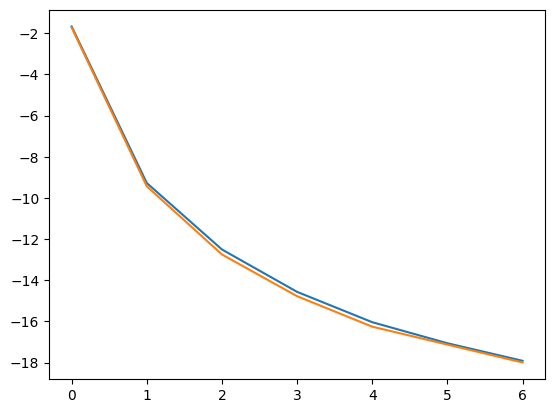

In [13]:
plt.plot([errors_experiment[SNR]['ALISTA'] for SNR in SNRs])
plt.plot([errors_experiment[SNR]['AL-DC-ISTA'] for SNR in SNRs])

In [ ]:
M = 10
LAYERS = 5
BETA_INIT = 0.4
EPOCHS = 50
SNR = None

ALISTA_LOSS = torch.zeros((M, LAYERS))
ALDC_LISTA_EXP_LOSS = torch.zeros((M, LAYERS))
ALDC_LISTA_PNEG_LOSS = torch.zeros((M, LAYERS))
ALDC_LISTA_SCAD_LOSS = torch.zeros((M, LAYERS))

ISTA_LOSS = torch.zeros((M, LAYERS))
FISTA_LOSS = torch.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 200
    m_ = 150
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = ALISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=True)

    model2 = ALDC_ISTA(torch.clone(A_), 'EXP', BETA_INIT, T = LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=True)

    model3 = ALDC_ISTA(torch.clone(A_), 'PNEG', BETA_INIT, T = LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = ALDC_ISTA(torch.clone(A_), 'SCAD', BETA_INIT, T = LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    ALISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set).cpu()
    ALDC_LISTA_EXP_LOSS[m,:] = model2.compute_nmse_inference(test_set).cpu()
    ALDC_LISTA_PNEG_LOSS[m,:] = model3.compute_nmse_inference(test_set).cpu()
    ALDC_LISTA_SCAD_LOSS[m,:] = model4.compute_nmse_inference(test_set).cpu()

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT).cpu()
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT).cpu()

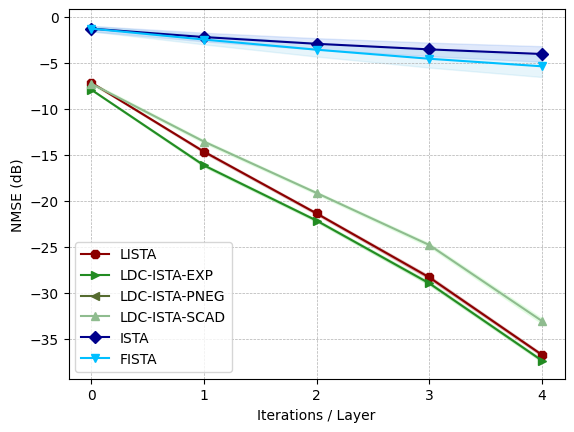

In [335]:
#ALISTA_LOSS = ALISTA_LOSS.cpu().numpy()
#ALDC_LISTA_EXP_LOSS = ALDC_LISTA_EXP_LOSS.cpu().numpy()
ALDC_LISTA_PNEG_LOSS = ALDC_LISTA_PNEG_LOSS.cpu().numpy()
ALDC_LISTA_SCAD_LOSS = ALDC_LISTA_SCAD_LOSS.cpu().numpy()

ISTA_LOSS = ISTA_LOSS.cpu().numpy()
FISTA_LOSS = FISTA_LOSS.cpu().numpy()

plt.plot(np.mean(ALISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(ALISTA_LOSS, axis = 0) - (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    np.mean(ALISTA_LOSS, axis = 0) + (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.2)

plt.plot(np.mean(ALDC_LISTA_EXP_LOSS, axis = 0), label='LDC-ISTA-EXP', color='forestgreen', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(ALDC_LISTA_EXP_LOSS, axis = 0) - (2/np.sqrt(ALDC_LISTA_EXP_LOSS.shape[1])) * np.std(ALDC_LISTA_EXP_LOSS, axis = 0), 
                    np.mean(ALDC_LISTA_EXP_LOSS, axis = 0) + (2/np.sqrt(ALDC_LISTA_EXP_LOSS.shape[1])) * np.std(ALDC_LISTA_EXP_LOSS, axis = 0), 
                    color='limegreen', 
                    alpha=0.2)

plt.plot(np.mean(ALDC_LISTA_PNEG_LOSS, axis = 0), label='LDC-ISTA-PNEG', color='darkolivegreen', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(ALDC_LISTA_PNEG_LOSS, axis = 0) - (2/np.sqrt(ALDC_LISTA_PNEG_LOSS.shape[1])) * np.std(ALDC_LISTA_PNEG_LOSS, axis = 0), 
                    np.mean(ALDC_LISTA_PNEG_LOSS, axis = 0) + (2/np.sqrt(ALDC_LISTA_PNEG_LOSS.shape[1])) * np.std(ALDC_LISTA_PNEG_LOSS, axis = 0), 
                    color='greenyellow', 
                    alpha=0.2)

plt.plot(np.mean(ALDC_LISTA_SCAD_LOSS, axis = 0), label='LDC-ISTA-SCAD', color='darkseagreen', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(ALDC_LISTA_SCAD_LOSS, axis = 0) - (2/np.sqrt(ALDC_LISTA_SCAD_LOSS.shape[1])) * np.std(ALDC_LISTA_SCAD_LOSS, axis = 0), 
                    np.mean(ALDC_LISTA_SCAD_LOSS, axis = 0) + (2/np.sqrt(ALDC_LISTA_SCAD_LOSS.shape[1])) * np.std(ALDC_LISTA_SCAD_LOSS, axis = 0), 
                    color='palegreen', 
                    alpha=0.2)

plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.xticks(range(LAYERS))

plt.ylabel('NMSE (dB)')
plt.xlabel('Iterations / Layer')


plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

In [66]:
class ALDC_ISTA(nn.Module):
    def __init__(self, A, mode, lambd=0.1, p =0.012, p_max = 0.12, T = 5):
        super().__init__()
    
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        assert mode in ['EXP', 'PNEG', 'SCAD']

        self.mode = mode

        self.A = A.to(self.device)  # Move A to the correct device
        self.A.requires_grad = False

        self.T = T

        self.L = torch.max(torch.real(torch.linalg.eigvals(A.t() @ A))).to(self.device)

        # Initialization of the learnable parameters
        self.mu = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) / self.L, requires_grad=True)
        self.lambd = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) * lambd, requires_grad=True)
        
        # Linear layers
        self.Z = torch.linalg.pinv(self.A.T).to(self.device) * lambd 

        self.W = self.W_optimization().to(self.device)
        self.W1 = torch.clone((self.W.T @ self.A)).to(self.device)
        self.W2 = torch.clone(self.W.T).to(self.device)
        self.W3  = torch.clone((self.W.T @ self.Z)).to(self.device)

        # Support selection mechanism parameters
        self.p = p
        self.p_max = p_max

        # Losses when doing inference (placeholder for NMSE accumulation)
        self.losses = torch.zeros(self.T, device=self.device)
        self.est_powers = torch.zeros(self.T, device=self.device)

        # Mode setting for the layer
        if mode == 'EXP':
            self.theta = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) * lambd /self.L, requires_grad=True)
            self.ddx = self.ddxEXP
            self.eta = self.etaEXP

        if mode == 'PNEG':
            self.theta = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) * (-lambd /(0.1*self.L)), requires_grad=True)
            self.P = - nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) *0.1, requires_grad=True)
            self.ddx = self.ddxNEG
            self.eta = self.etaNEG

        if mode == 'SCAD':
            self.theta = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) * 1.5 * lambd / self.L, requires_grad=True)
            self.a = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) * 2, requires_grad=True)
            self.ddx = self.ddxSCAD
            self.eta = self.etaSCAD
    
    #_________________________________________________________________
    #______________ METHODS FOR ENABLING DIFFERENT LAYERS_____________
    #_________________________________________________________________

    def W_optimization(self):
        N, M = self.A.shape
        W = cp.Variable((N, M))

        objective = cp.Minimize(cp.norm(W.T @ self.A.cpu().numpy(), 'fro'))
        constraints = [W[:, m].T @ self.A.cpu().numpy()[:, m] == 1 for m in range(M)]
        prob = cp.Problem(objective, constraints)

        prob.solve(solver=cp.MOSEK)
        print('Linear layer initialized minimizing coherence!')
        return torch.from_numpy(W.value).float()
    
    # Derivatives of the nonconvex components
    def ddxEXP(self, x, t):
        return torch.sign(x) * self.theta[t,:,:] * (1 - torch.exp(-self.theta[t,:,:] * torch.abs(x)))

    def ddxNEG(self, x, t):
        return -torch.sign(x) * self.P[t,:,:] * self.theta[t,:,:] * (1 - (1 + self.theta[t,:,:] * torch.abs(x)) ** (self.P[t,:,:] - 1))

    def ddxSCAD(self, x, t):
        abs_x = torch.abs(x)

        mask1 = (abs_x <= 1)
        mask2 = (1 / self.theta[t,:,:] < abs_x) & (abs_x <= self.a[t,:,:] / self.theta[t,:,:])
        mask3 = (abs_x > self.a[t,:,:] / self.theta[t,:,:])

        # Compute the value for each condition
        val1 = torch.zeros_like(x)
        val2 = torch.sign(x) * (2 * self.theta[t,:,:] * (self.theta[t,:,:] * abs_x - 1)) / (self.a[t,:,:] ** 2 - 1)
        val3 = torch.sign(x) * (2 * self.theta[t,:,:] / (self.a[t,:,:] + 1))

        # Apply the masks to compute the final result
        result = torch.where(mask1, val1, torch.where(mask2, val2, val3))

        return result

    # Parametrization for the surrogates
    def etaEXP(self, t):
        return self.theta[t,:,:]

    def etaNEG(self, t):
        return -self.P[t,:,:] * self.theta[t,:,:]

    def etaSCAD(self, t):
        return 2 * self.theta[t,:,:] / (self.a[t,:,:] + 1)
    
    #___________________________________________________________________
    #___________________________________________________________________
        
    def _shrink(self, x, beta, t):
        # Get the absolute values of the elements in x
        abs_x = torch.abs(x)
        
        # Sort the elements of x by magnitude along the last dimension (num_features)
        sorted_abs_x, _ = torch.sort(abs_x, dim=-1, descending=True)

        # Determine the threshold index corresponding to the top p% elements in each sample
        p = torch.min(torch.tensor([self.p * t, self.p_max], device=self.device))
        threshold_idx = int(p * x.shape[-1])
        
        # Get the magnitude threshold for the top p% of elements (per batch)
        if threshold_idx > 0:
            threshold_value = sorted_abs_x[:, threshold_idx - 1:threshold_idx]  # Shape: (batch_size, 1)
        else:
            threshold_value = torch.zeros(x.shape[0], 1, device=x.device)  # Shape: (batch_size, 1)

        # Create a mask to exclude the top p% of elements from shrinkage
        mask = abs_x >= threshold_value
        
        # Apply soft thresholding only to elements outside the top p%
        x_shrink = beta * F.softshrink(x / beta, lambd=1)
        
        # Return the original values for the top p% and the shrinked values for others
        return torch.where(mask, x, x_shrink)

    
    def forward(self, y, S=None):     
        # Move inputs to the correct device
        y = y.to(self.device)
        if S is not None:
            S = S.to(self.device)

        # Initial sparse estimate using the first layer
        x = self._shrink(self.mu[0, :, :] * torch.matmul(y, self.W2.t()), self.eta(0) * self.lambd[0,:,:] * self.mu[0,:,:], 0)
        
        # Loop over layers to refine the estimate
        for t in range(1, self.T + 1):
            x = self._shrink(x - self.mu[t, :, :] * (torch.matmul(x, self.W1.t()) - torch.matmul(y, self.W2.t()) + torch.matmul(self.ddx(x, t), self.W3.t())), 
                             self.eta(t) * self.lambd[t,:,:] * self.mu[t,:,:],
                             t)
            
            if S is not None:  # During inference, compute the NMSE at each layer
                with torch.no_grad():
                    mse_loss = F.mse_loss(x.detach(), S.detach(), reduction="sum")
                    signal_power = torch.sum(S.detach() ** 2)

                    self.losses[t - 1] += mse_loss.item()
                    self.est_powers[t - 1] += signal_power.item() + 1e-6

        return x

    # Method to compute NMSE during inference mode
    def compute_nmse_inference(self, test_loader):
        # Reset the losses accumulator
        self.losses = torch.zeros(self.T, device=self.device)
        
        # Iterate over test_loader
        for _, (Y, S) in enumerate(test_loader):
            Y, S = Y.to(self.device), S.to(self.device)
            _ = self.forward(Y, S)  # This will accumulate NMSE values
        
        # Convert accumulated NMSE to dB
        nmse_db = 10 * torch.log10(self.losses / self.est_powers)
        
        # Reset the losses after inference
        self.losses = torch.zeros(self.T, device=self.device)
        self.est_powers = torch.zeros(self.T, device=self.device)

        # Return NMSE in dB for each layer
        return nmse_db

__________

In [38]:
class TiLDC_ISTA(nn.Module):
    def __init__(self, A, mode, lambd=0.1, p =0.012, p_max = 0.12, T = 5):
        super().__init__()
    
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        assert mode in ['EXP', 'PNEG', 'SCAD']

        self.mode = mode

        self.A = A.to(self.device)  # Move A to the correct device
        self.A.requires_grad = False

        self.T = T

        self.L = torch.max(torch.real(torch.linalg.eigvals(A.t() @ A))).to(self.device)

        # Initialization of the learnable parameters
        self.mu = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) / self.L, requires_grad=True)
        
        # Linear layers
        self.W1 = nn.Linear(A.shape[1], A.shape[0], bias=False).to(self.device)
        self.W1.weight.data = torch.clone(self.A.T).to(self.device) 

        self.W2 = nn.Linear(A.shape[1], A.shape[1], bias=False).to(self.device)


        # Support selection mechanism parameters
        self.p = p
        self.p_max = p_max

        # Losses when doing inference (placeholder for NMSE accumulation)
        self.losses = torch.zeros(self.T, device=self.device)
        self.est_powers = torch.zeros(self.T, device=self.device)

        # Mode setting for the layer
        if mode == 'EXP':
            self.theta = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) * lambd /self.L, requires_grad=True)
            self.ddx = self.ddxEXP
            self.eta = self.etaEXP

        if mode == 'PNEG':
            self.theta = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) * (-lambd /self.L), requires_grad=True)
            self.P = - nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) * 1, requires_grad=True)
            self.ddx = self.ddxNEG
            self.eta = self.etaNEG

        if mode == 'SCAD':
            self.theta = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) * 1.5 * lambd / self.L, requires_grad=True)
            self.a = nn.Parameter(torch.ones(self.T + 1, 1, 1).to(self.device) * 2, requires_grad=True)
            self.ddx = self.ddxSCAD
            self.eta = self.etaSCAD

    #_________________________________________________________________
    #______________ METHODS FOR ENABLING DIFFERENT LAYERS_____________
    #_________________________________________________________________
    
    # Derivatives of the nonconvex components
    def ddxEXP(self, x, t):
        return torch.sign(x) * self.theta[t,:,:] * (1 - torch.exp(-self.theta[t,:,:] * torch.abs(x)))

    def ddxNEG(self, x, t):
        return -torch.sign(x) * self.P[t,:,:] * self.theta[t,:,:] * (1 - (1 + self.theta[t,:,:] * torch.abs(x)) ** (self.P[t,:,:] - 1))

    def ddxSCAD(self, x, t):
        abs_x = torch.abs(x)

        mask1 = (abs_x <= 1)
        mask2 = (1 / self.theta[t,:,:] < abs_x) & (abs_x <= self.a[t,:,:] / self.theta[t,:,:])
        mask3 = (abs_x > self.a[t,:,:] / self.theta[t,:,:])

        # Compute the value for each condition
        val1 = torch.zeros_like(x)
        val2 = torch.sign(x) * (2 * self.theta[t,:,:] * (self.theta[t,:,:] * abs_x - 1)) / (self.a[t,:,:] ** 2 - 1)
        val3 = torch.sign(x) * (2 * self.theta[t,:,:] / (self.a[t,:,:] + 1))

        # Apply the masks to compute the final result
        result = torch.where(mask1, val1, torch.where(mask2, val2, val3))

        return result

    # Parametrization for the surrogates
    def etaEXP(self, t):
        return self.theta[t,:,:]

    def etaNEG(self, t):
        return -self.P[t,:,:] * self.theta[t,:,:]

    def etaSCAD(self, t):
        return 2 * self.theta[t,:,:] / (self.a[t,:,:] + 1)
    
    #___________________________________________________________________
    #___________________________________________________________________
        
    def _shrink(self, x, beta, t):
        # Get the absolute values of the elements in x
        abs_x = torch.abs(x)
        
        # Sort the elements of x by magnitude along the last dimension (num_features)
        sorted_abs_x, _ = torch.sort(abs_x, dim=-1, descending=True)

        # Determine the threshold index corresponding to the top p% elements in each sample
        p = torch.min(torch.tensor([self.p * t, self.p_max], device=self.device))
        threshold_idx = int(p * x.shape[-1])
        
        # Get the magnitude threshold for the top p% of elements (per batch)
        if threshold_idx > 0:
            threshold_value = sorted_abs_x[:, threshold_idx - 1:threshold_idx]  # Shape: (batch_size, 1)
        else:
            threshold_value = torch.zeros(x.shape[0], 1, device=x.device)  # Shape: (batch_size, 1)

        # Create a mask to exclude the top p% of elements from shrinkage
        mask = abs_x >= threshold_value
        
        # Apply soft thresholding only to elements outside the top p%
        x_shrink = beta * F.softshrink(x / beta, lambd=1)
        
        # Return the original values for the top p% and the shrinked values for others
        return torch.where(mask, x, x_shrink)

    
    def forward(self, y, S=None):     
        # Move inputs to the correct device
        y = y.to(self.device)
        if S is not None:
            S = S.to(self.device)

        # Initial sparse estimate using the first layer
        x = self._shrink(self.mu[0, :, :] * self.W1(y), self.eta(0), 0)
        
        # Loop over layers to refine the estimate
        for t in range(1, self.T + 1):
            x = self._shrink(x - self.mu[t, :, :] * self.W1(torch.matmul(x, self.A.t()) - y) + self.eta(t) * self.ddx(x, t),
                             self.eta(t),
                             t)
            
            if S is not None:  # During inference, compute the NMSE at each layer
                with torch.no_grad():
                    mse_loss = F.mse_loss(x.detach(), S.detach(), reduction="sum")
                    signal_power = torch.sum(S.detach() ** 2)

                    self.losses[t - 1] += mse_loss.item()
                    self.est_powers[t - 1] += signal_power.item() + 1e-6

        return x

    # Method to compute NMSE during inference mode
    def compute_nmse_inference(self, test_loader):
        # Reset the losses accumulator
        self.losses = torch.zeros(self.T, device=self.device)
        
        # Iterate over test_loader
        for _, (Y, S) in enumerate(test_loader):
            Y, S = Y.to(self.device), S.to(self.device)
            _ = self.forward(Y, S)  # This will accumulate NMSE values
        
        # Convert accumulated NMSE to dB
        nmse_db = 10 * torch.log10(self.losses / self.est_powers)
        
        # Reset the losses after inference
        self.losses = torch.zeros(self.T, device=self.device)
        self.est_powers = torch.zeros(self.T, device=self.device)

        # Return NMSE in dB for each layer
        return nmse_db

In [28]:
M = 10
LAYERS = 5
BETA_INIT = 0.4
EPOCHS = 50
SNR = 10

TiLISTA_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_EXP_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_PNEG_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_SCAD_LOSS = torch.zeros((M, LAYERS))

ISTA_LOSS = torch.zeros((M, LAYERS))
FISTA_LOSS = torch.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 200
    m_ = 150
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = TiLISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = TiLDC_ISTA(torch.clone(A_), 'EXP', BETA_INIT, T = LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = TiLDC_ISTA(torch.clone(A_), 'PNEG', BETA_INIT, T = LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = TiLDC_ISTA(torch.clone(A_), 'SCAD', BETA_INIT, T = LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    TiLISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_EXP_LOSS[m,:] = model2.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_PNEG_LOSS[m,:] = model3.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_SCAD_LOSS[m,:] = model4.compute_nmse_inference(test_set).cpu()

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT).cpu()
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT).cpu()

100%|██████████| 10/10 [10:42<00:00, 64.23s/it]


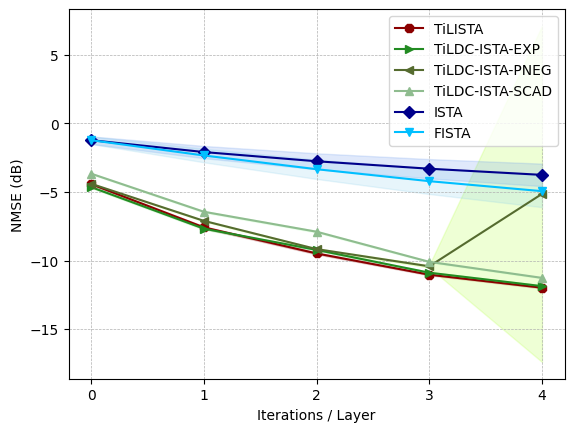

In [29]:
TiLISTA_LOSS = TiLISTA_LOSS.cpu().numpy()
TiLDC_LISTA_EXP_LOSS = TiLDC_LISTA_EXP_LOSS.cpu().numpy()
TiLDC_LISTA_PNEG_LOSS = TiLDC_LISTA_PNEG_LOSS.cpu().numpy()
TiLDC_LISTA_SCAD_LOSS = TiLDC_LISTA_SCAD_LOSS.cpu().numpy()

ISTA_LOSS = ISTA_LOSS.cpu().numpy()
FISTA_LOSS = FISTA_LOSS.cpu().numpy()

plt.plot(np.mean(TiLISTA_LOSS, axis = 0), label='TiLISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLISTA_LOSS, axis = 0) - (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    np.mean(TiLISTA_LOSS, axis = 0) + (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0), label='TiLDC-ISTA-EXP', color='forestgreen', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_EXP_LOSS.shape[1])) * np.std(TiLDC_LISTA_EXP_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_EXP_LOSS.shape[1])) * np.std(TiLDC_LISTA_EXP_LOSS, axis = 0), 
                    color='limegreen', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0), label='TiLDC-ISTA-PNEG', color='darkolivegreen', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_PNEG_LOSS.shape[1])) * np.std(TiLDC_LISTA_PNEG_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_PNEG_LOSS.shape[1])) * np.std(TiLDC_LISTA_PNEG_LOSS, axis = 0), 
                    color='greenyellow', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0), label='TiLDC-ISTA-SCAD', color='darkseagreen', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_SCAD_LOSS.shape[1])) * np.std(TiLDC_LISTA_SCAD_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_SCAD_LOSS.shape[1])) * np.std(TiLDC_LISTA_SCAD_LOSS, axis = 0), 
                    color='palegreen', 
                    alpha=0.2)

plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.xticks(range(LAYERS))

plt.ylabel('NMSE (dB)')
plt.xlabel('Iterations / Layer')


plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

In [25]:
M = 10
LAYERS = 5
BETA_INIT = 0.4
EPOCHS = 50
SNR = 10

TiLISTA_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_EXP_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_PNEG_LOSS = torch.zeros((M, LAYERS))
TiLDC_LISTA_SCAD_LOSS = torch.zeros((M, LAYERS))

ISTA_LOSS = torch.zeros((M, LAYERS))
FISTA_LOSS = torch.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 200
    m_ = 150
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = TiLISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = TiLDC_ISTA(torch.clone(A_), 'EXP', BETA_INIT, T = LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = TiLDC_ISTA(torch.clone(A_), 'PNEG', BETA_INIT, T = LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = TiLDC_ISTA(torch.clone(A_), 'SCAD', BETA_INIT, T = LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    TiLISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_EXP_LOSS[m,:] = model2.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_PNEG_LOSS[m,:] = model3.compute_nmse_inference(test_set).cpu()
    TiLDC_LISTA_SCAD_LOSS[m,:] = model4.compute_nmse_inference(test_set).cpu()

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT).cpu()
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT).cpu()

100%|██████████| 10/10 [09:58<00:00, 59.85s/it]


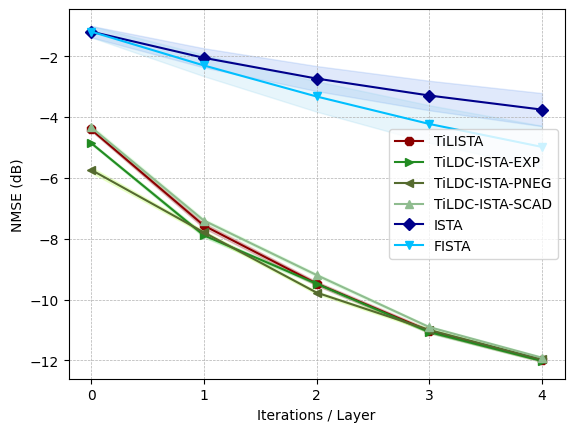

In [26]:
TiLISTA_LOSS = TiLISTA_LOSS.cpu().numpy()
TiLDC_LISTA_EXP_LOSS = TiLDC_LISTA_EXP_LOSS.cpu().numpy()
TiLDC_LISTA_PNEG_LOSS = TiLDC_LISTA_PNEG_LOSS.cpu().numpy()
TiLDC_LISTA_SCAD_LOSS = TiLDC_LISTA_SCAD_LOSS.cpu().numpy()

ISTA_LOSS = ISTA_LOSS.cpu().numpy()
FISTA_LOSS = FISTA_LOSS.cpu().numpy()

plt.plot(np.mean(TiLISTA_LOSS, axis = 0), label='TiLISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLISTA_LOSS, axis = 0) - (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    np.mean(TiLISTA_LOSS, axis = 0) + (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0), label='TiLDC-ISTA-EXP', color='forestgreen', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_EXP_LOSS.shape[1])) * np.std(TiLDC_LISTA_EXP_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_EXP_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_EXP_LOSS.shape[1])) * np.std(TiLDC_LISTA_EXP_LOSS, axis = 0), 
                    color='limegreen', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0), label='TiLDC-ISTA-PNEG', color='darkolivegreen', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_PNEG_LOSS.shape[1])) * np.std(TiLDC_LISTA_PNEG_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_PNEG_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_PNEG_LOSS.shape[1])) * np.std(TiLDC_LISTA_PNEG_LOSS, axis = 0), 
                    color='greenyellow', 
                    alpha=0.2)

plt.plot(np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0), label='TiLDC-ISTA-SCAD', color='darkseagreen', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0) - (2/np.sqrt(TiLDC_LISTA_SCAD_LOSS.shape[1])) * np.std(TiLDC_LISTA_SCAD_LOSS, axis = 0), 
                    np.mean(TiLDC_LISTA_SCAD_LOSS, axis = 0) + (2/np.sqrt(TiLDC_LISTA_SCAD_LOSS.shape[1])) * np.std(TiLDC_LISTA_SCAD_LOSS, axis = 0), 
                    color='palegreen', 
                    alpha=0.2)

plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.xticks(range(LAYERS))

plt.ylabel('NMSE (dB)')
plt.xlabel('Iterations / Layer')


plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()